# A: Uncertainty Modeling

Polymorphic Uncertainties are considered. The model contains scalar input parameters, as well as sequences as input parameters or input signals. The latter can be modeled as polymorphically uncertain processes. As pointed out in Graf 2014 different variants exist to model these.
 - Perform a  polymorphic uncertainty analysis at each timestep (variant I)
 - Perform deterministic analyzes using a realization of the input sequence with a scalar result, which can be processed in an polymorphic uncertainty analysis (variant II)
We choose the latter.

# 1. Physical Structure (only aleatory uncertainties in the responses/time series)

The cross-section of the mast is changed from a pipe to a rectangular truss structure to avoid modeling cross-wind vibrations.

The truss structure is based on pictures from Sender Aholming, a guyed truss mast, and parameters are chosen such that mass per meter and second area of moments equal that of the pipe structure, thus previous results can be used.

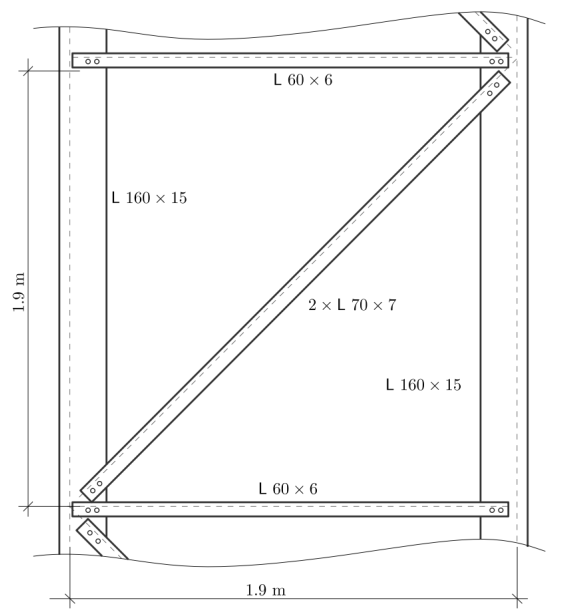

The truss consist of equal leg steel angle profiles. The corners are 160 x 15, the horizontal members are 60 x 6 and the diagonals are two 70 x 7 bolted together on either side of the corner members flange.

The cross-section can be rotated randomly about angle $\alpha$ to contain modes of both directions in each sensor signal and also make sure, the equivalent springs do not act in the principal directions of the cross-section.

Wind excitation is based on EN 1991-1-4 with parameters from [Clobes 2008] and the method given by [Solari 2001], [Shinozuka 1972]. Wind direction is fixed to the models coordinate system, as the cross-section can be rotated w.r.t. the wind direction. Basic wind speed $v_b$ (given fixed in EN 1991-1-4) could be considered as random (Weibull, with parameters as estimated from Geyer monitoring data: $c={0.75:[2.267, 2.3],0.25:[1.96, 2.01]}$, $\lambda={0.75:[5.618, 5.649], 0.25:[5.91,6.0]}$, parameters seem to be independent $\rho= {0.03, 0.3}$).  (Turbulence intensity is proportional to category only and then scales sigma w.r.t. wind speed.)

Wind excitation is computed in the full frequency range that is considered for the model. Otherwise the response mostly vanishes above the wind spectrum, which would mean, these frequency bands would not have to be considered at all.


Other parameters such as integral lengths $L(z)$, correlation lengths $C_{k,j}$ ($k: {u,v,w}, j: {x,y,z}$), spectral bandwidth $f_{s,w}$ will be considered fixed for now.

#### Given parameters (sample Nr. 566)

$E = 2.1e11$ N m^-2                                          Young's Modulus                                       
$\rho = 7850$ kg m^-3                                        Mass density                                          
$A = 0.03287$ m                                              equivalent cross-section area (average per meter)     
$I_y = 0.01196 $ m^4                                         second moment of area (equivalent of a truss. 80 %)   
$I_z = 0.01304 $ m^4                                         second moment of area (equivalent of a truss. 80 %)   
$\alpha=\frac{\pi}{4}$                                       Angle of cross-section rotation                       
$m_\text{add} = 60$ kg m^-1                                  Additional Mass (Platforms, Cables, Antennas, etc.)   
$N_\text{cbl} = 60 000$ N                                    Pretension of guy cables  (Normal distr.)             
$A_\text{cbl} = 0.00075$ m^2                                 Cross-Sectional Area of cables                          
$d_\text{D} = 200$ Nsm^-1                                    TMD viscosity due to temperature-dependent silicon-oil
$m_\text{D} = 800$ kg                                        TMD mass                                              
$k_{\mathrm{D}} = 1025.48$ Nm^-1                             TMD stiffness                                         
$n_\text{nodes} = 201 + 1 $                                  Number of nodes, excl. internal nodes

#### Problems to be decided:

- Mode shapes should be scaled to unity at the mast tip? no, can be done later
- FRF-based solution will be used (FRF can be precomputed, modal parameters, modeshapes and other parameters are computed once)
    - FRF generation of 360001x402x406 with 46 modes took: 440 GB memory and 840 CPU minutes (parallel numba)
    - Response generation took 70 CPU minutes (parallizable)
    - Excitation generation took: 220 GB memory and 42 CPU minutes
- In the random loop of the first step: generate and save windfield, load FRF, compute and save response

#### Case studies with respect to closely-spaced modes (variables $ I_y, I_z, \alpha$) and global damping (variable $\zeta$)

A) $\zeta = 0.002$ (reference)  
B) $\zeta = 0.0005$ (light damping)  
C) $\zeta = 0.005$ (heavy damping)  
D) $I_y=0.01239$, $I_z=0.01261$, $\alpha=\mathcal{U}(0,\pi)$ (closely-spaced modes)  
E) $\zeta = f(v_b)$ (Amplitude dependent damping)

#### Parameters to be set based on assumptions in subsequent steps:
- Solution time-step: -> $f_s = 100 Hz$
    - for frf-based: corresponding to highest sampling rate max(f_s)
    - for time integration: Should be much smaller than for any desired sampling rate, will be increased in signal acquisition step, corresponding to 10 x max(f_s)
- Solution max length: Will be shortened in signal acqusition step -> based on max measurement duration max(d) -> 1.000 cycles of min(f) -> 1000/0.15 = 6666 s ~ 2 hours
- Solution No. channels: Will be reduced in signal acquisition step -> all (depending on storage requirements and numerical cost)
- Number of modes $n_m$: highest mode in bandwidth corresponding to the solution time-step -> 46 (see plot below structural model generation)

#### Outputs (for verification only, not for uq)#
- (modal parameters are constant)
- polar force amplitude mean and std over time ndarray(202,)
- polar force direction mean and std over time ndarray(202,)
- RMS of d, v, a over time 3 x ndarray(202, 2)

## 2. Sensors / Signal Acquisition

Scenario: Multiple experts have been asked, how they would choose the parameters / what they believe are the ranges of the parameters:

#### Placement of Sensors
- $n_\mathrm{chan} = $ Number of channels {0.2:8,0.5:16,0.3:24}next
- Placement of sensors: evenly distributed, every five meters, mimicking multi-setup measurements; both directions simultaneously
- Setup no.: random based on jid

#### Type of Sensors
- Measurement quantity: acceleration
- Sensitivity :
    - $\overline{\mathcal{H}}$ nominal {0.5: [1.02,]; 0.3:[1.02,0.102]; 0.2:[0.51,0.01]} Vm^-1s^2
    - $\Delta \mathcal{H}$ deviation {0.4:5.; 0.4:10.; 0.1:[2,20]; 0.1:nan} # open world assumption
- Sensor spectral noise
    - Spectral Noise slope {1.0:[-0.8,-0.3]}
    - Spectral Noise RMS {1.0:[1e-6,1e-2]}
- Discharge Time Constant of the sensor 
    - (Assumption: includes the built-in highpass of the DAQ)
    - $\operatorname{DTC} [s] = ${0.7:[1.6,30]; 0.2:[0.8,1.6]; 0.1:[0.4,0.8]} 

#### Signal acquisition system
- Broadband Resolution
    - $q = $ Quantization range. <br> Estimated based on a sample of xx seconds and a user provided margin
        - Sample duration {0.2:30,0.5:[60,120],0.3:300}
        - margin {0.2:2,0.5:5,0.3:10}
    - $b = [0.1:12, 0.3:16, 0.6:24]$ Number of quantization bits 
- Aliasing Filter (IIR: Butterworth)
    - $f_c = $ {0.7:[0.4 f_s, 0.45 f_s]; 0.2:[0.45 fs, 0.49 fs]; 0.1:0.5f_s} Filter 3 dB cutoff frequency [Hz]
    - $n = 4$ Filter order
- $f_s = $ {0.5:[35,70], 0.3:[10,35], 0.2:[4,10] } [Hz]<br> Sample rate, strategies: large oversampling (+ pre-OMA decimation), moderate oversampling (maybe pre-OMA decimation), sampling the final bandwidth
- The process model uses decimation to get a desired sampling rate from model responses sampled at 70 Hz, so these ranges rougly translate to:
- integer decimation factors $d_s = $ {0.5:[1,2], 0.3:[2,7], 0.2:[7,18] } 
- Measurement Duration $T = N \Delta t$ {0.1:[10,20], 0.2:[30,45],0.5:60,0.2:120} [minutes]
- ($N = T / \Delta t$ Number of Timesteps)
- $\operatorname{SNR}_\mathrm{acq} = {1.0:[2.5e-6, 3e-3]} [VRMS]$ Acquisition system noise variance (pre-sampling, white noise) <br>

- The epistemic uncertainty due to sensors is, whether suitable sensors have been chosen
- suitability is due to 
    - the sensor frf fitting the bandwitdth of structural vibrations to be measured
    - the sensor noise profile being low enough to not hide any structural vibration
- How to model the uncertainty in this step of the process?
    - Inexperienced users just choose any sensor they have
    - Experienced users are able to estimate vibration levels and frequency bands of interest beforehand
    - basically we have 25 discrete choices
    - cluster them in three groups with masses: suitable:0.3, maybe suitable:0.5, not suitable:0.2 (order groups, so we can optimize over integer ranges)
    - put another way, experts would classify each sensor, as suitable or not, then we can use dempster's rule to combine available evidence -> so we assign mass to our experts and transfer it to sensors. now, how do we proceed from here in out measurement process simulation uq?
    - this is somehow inverse to the usual proceeding
    
All hardware parameter (measurement quantity, sensor frequency response, sensor noise, quantization bits, aliasing cutoff, daq noise) are not so much uncertainties but rather choices. What is needed are **case studies**: 
- suitable hardware, 
- maybe suitable hardware, 
- non-suitable hardware, 
rather than mixing and hiding everything under the cover of uncertainties. By doing interval optimization of the final output variable over bad and good sensors combined we would get huge intervals, which is expected and has no relation to reality. Here, usually some type of hardware is available and can be rated with regards to suitability and we are interested to know how much it affects the final output uncertainty. 

So, we would still sample hardware in the epistemic space and the optimize over all the samples, whith the right combination of hardware. To make it easier to apply optimizers, hardware should be ordered by suitability and we can optimize over integer ranges, instead of discrete choices. **TODO: check, that integers are supported by optimizers**
**TODO: check, whether useful to implement the vacuous extension**



#### Outputs
- Effective quantization bits [Channel average] (Considering quantization range, bits and actual vibration level)
- Total SNR
- Estimated SNR

## 3. Signal processing / System identification

#### Signal processing (Consider two analyses in different frequency bands)
- Filter and Decimation (IIR Filter)
    - $M = $ Number of IIR filter coefficients ("order")
    - $f_c =$ Filter 3 dB cutoff frequency
    - $d = $ Decimation rate (every d-th sample)
- $\hat{\Phi}(\omega)$ Spectral estimator (Welch, Blackman-Tukey)
    - Time / Lag Window (If PSDs are involved)  <br>**TODO: Which window types to include (rectangular, hanning, hamming, etc.)?**
    - $ 2 (n_\mathrm{lags} - 1) = n_\mathrm{lines}$ Number of time lags ↔ number of frequency lines ($\tau_\mathrm{max} = n_\mathrm{lags} \Delta t$ Correlation length ↔ Frequency Resolution $\Delta f = \frac{f_s}{n_\mathrm{lines}}$)
- use non-reference based OMA ($n_\mathrm{ref}$ Number and $\operatorname{loc}_\mathrm{ref}$ location of reference channels) 

#### Systemidentification
- $n_\mathrm{ord}^\mathrm{max} = $ max model order
- Identification Algorithm (SSI-cov, SSI-data, pLSCF) -> Three case studies, pLSCF might need some work in terms of verification, efficiency, etc.

#### Outputs
- PSD Energy
- **TODO: Cross-validated reconstruction error of the identified system**

## 4. Modal Analysis

#### Parameters 
- $n_\mathrm{ord} = $ Model order -> Clustern!
- $f_\mathrm{max} = $ largest natural frequency of interest

#### Outputs: 
- Store identified modal in the database regardless of assignment to physical modes
- Modal Frequencies
- Modal Damping
- Complex mode shapes at all DOFs (linear interpolation for UQ Processing)
- MPC, (Modal Contributions)
- Selected model order
- Number of modes


# B. Uncertainty Propagation

- Two steps: 
    1. Generate detailed (space and time) structural responses (mostly deterministic, only aleatory uncertainties in the response signals)
    2. Apply Signal Acqusition, Processsing, SysID and Modal onto this data (epistemic and aleatory)
- $N_\mathrm{MCS, ale} = $ Number of samples for aleatory uncertainties (sufficient statistical confidence)
- $N_\mathrm{MCS, epi} = $ Number of samples for epistemic uncertainties (sufficiently small cross-validation error in RBF interpolation)

# C. Uncertainty Processing

**Which outputs do we want to process?**
- Modal Frequencies and Modal damping -> **TODO: Classification / Clustering/ Assignment necessary**
- Mode shapes? -> Would have to be done individually for each DOF, with linear interpolation for unmeasured DOFs

**Which intermediate outputs do we need in the UQ Database? (Others are still stored with the samples)**
- Numerical modal parameters 
- Spectra
- Modal Contributions, MPC, MPD, 
- Signal-to-Noise-Ratio, Effective quantization bits,

**How can we include the existing OMA UQ Methods (aleatory only) in this methodology (in principle it is possible):** 
- Technical details:
    - SSI would take the place of a statistical estimator
    - We would need to **incorporate weights into the routines**
    - The imprecision processing would not be possible, because the modal parameters are not yet available
    - Pre-generation of modal parameters for each imprecision sample not possible due to unknown weights (incompleteness)
    - We have to **combine imprecision and incompleteness processing**
        1. **direct optimization (not feasible):**
            - for each optimizer step: 
                - for each aleatory sample:
                    - compute weights, 
                    - find nearestND impprecision sample (and compute / retrieve correlation function)
                - run modal analysis algorithm
                - select mode of interest, discard other modes -> **useless, too much overhead**
        2. **sample incompleteness along epistemic direction**
            - for each epistemic sample: <br>
                A given aleatory sample may be the bound of any imprecision hypercube. A given imprecision sample thus may be in any of these imprecision hypercubes, in particular after interpolation. So it may have different weights for each imprecision hypercube.
                - for each imprecision hypercube: **(what if the epistemic sample is not in the hypercube?)**
                    - for each aleatory sample:
                        - generate weights
                        - compute / retrieve correlation function
                    - run modal analysis and clustering
                    - store all modes
            - **cluster / classify modes (fuzzy membership?)**
            - select quantity and mode of interest
            - fit an RBF interpolator
            - interval optimization within all imp+inc hypercubes
            - (validate found interval bounds)
            - Procedure:
                1. run DataManager on aleatory samples to generate signals
                2. run DataManager on epistemic samples to identify modes
                    would access all aleatory samples, weights must be provided by freezing inc variable for each epistemic sample and run self.probabilities_imp()
- Fuzzy clustering, etc.

**Do we have to consider anything else regarding further steps (Uncertainty reduction, ANN training, applicability to real measurements, etc.) such that data can be "re-cyled"?**
- Uncertainty reduction and ANN training would include uncertainties of the first step as well
- real measurements would be plugged in instead of generated signals

# Code

In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
sys.path.append("/home/sima9999/code/")
sys.path.append("/home/sima9999/git/pyOMA/")
from pathlib import Path


import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from examples.UQ_OMA import mapping, default_mapping, stage1mapping, stage1bmapping, stage2mapping, stage3mapping, stage2n3mapping, vars_definition, multi_sensi, sensitive_vars

import ray
import xarray as xr

from uncertainty.polymorphic_uncertainty import PolyUQ, plot_focals, stat_fun_avg, stat_fun_hist, stat_fun_cdf, generate_histogram_bins, aggregate_mass
from uncertainty.data_manager import DataManager

from helpers import get_pcd

import logging
logger= logging.getLogger('uncertainty.data_manager')
logger.setLevel(level=logging.INFO)

%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas - scipy.stats 

In [2]:
result_dir = Path('/scratch/sima9999/modal_uq/uq_oma_a/')
working_dir = Path('/dev/shm/womo1998/')

## Distributed Processing

### stage 1 (mech, wind, response)

In [ ]:
vars_ale, vars_epi, arg_vars = vars_definition(stage=1)
dim_ex = 'cartesian'

# %%snakeviz
N_mcs_ale = 1000 # N_mcs = 1e6 = N_mcs_ale * N_mcs_epi
N_mcs_epi = 1 # = 3^6 = 2.56^n_imp ~ 3^n_imp -> cover every corner and midpoints in a full-factorial design (but distributed)
use_dm = True



In [ ]:
poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
if False:
    
    poly_uq.sample_qmc(N_mcs_ale, N_mcs_epi, check_sample_sizes=False, seed=1165763483)
    display(poly_uq.var_supp)
    poly_uq.save_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
else:
    poly_uq.load_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
    
if True:
    import seaborn as sns
    sns.pairplot(poly_uq.inp_samp_prim, kind='hist')

if True:
    dm_grid, dm_ale, dm_epi = poly_uq.to_data_manager('dm_oma_a', result_dir=result_dir / 'samples')
else:
    dm_grid = None


In [ ]:
dm_grid = None
if dm_grid is None:
    dm_grid = DataManager.from_existing('dm_oma_a.nc',
                                        result_dir = result_dir / 'samples', 
                                        working_dir = '/dev/shm/womo1998/')

todo = False    

while todo:    
    todo = dm_grid.evaluate_samples(stage1mapping, arg_vars, 
                         ret_names={'mFm':('node',), 'sFm':('node',), 
                                    'mFd':('node',), 'sFd':('node',), 
                                    'RMSd':('node','dir'),'RMSv':('node','dir'),'RMSa':('node','dir'),}, default_len={'node':203, 'dir':2}, 
                         use_lock=False, dry_run=False, re_eval_sample=False, distributed=False,
                         chunks_submit=20, chunks_save=2, scramble_evaluation=False,
                                   remote_kwargs={'num_cpus':1})


In [ ]:
ray.shutdown()

In [ ]:
with dm_grid.get_database('out', rw=False) as out_ds, dm_grid.get_database('in', rw=False) as in_ds:
    # display(in_ds)
    # display(out_ds)
    node = 199
    plt.figure()
    v_b = in_ds['v_b']
    for node in [1,10,50,100,130,160,190,200,201,202]:
    
        out = out_ds['RMSd'].loc[{'node':node, 'dir':1}]
        plt.scatter(v_b, out, s=1, label=str(node))
    plt.legend()
    
    

In [ ]:
irun=1
with dm_grid.get_database('in') as db:
    for jid in db.ids:
        jid = jid.item()
        print(jid)
        v_b = db['v_b'].sel(ids=jid).data


        zeta = 0.002 # normal damping
        # zeta = 0.0005 # light damping
        # zeta = 0.005 # heavy damping
        Iy = 0.01196
        Iz = 0.01304
        alpha = 45

        fs_m = 70
        duration = 2**19/fs_m
        
        
        
        skip_existing = True


        success = mapping(zeta=zeta, Iy=Iy, Iz=Iz, alpha=alpha, 
                    v_b=v_b, fs_m=fs_m, duration=duration, 
                    jid=jid, result_dir=result_dir / 'samples', working_dir='/dev/shm/womo1998/', skip_existing=skip_existing)
        print(success)

### stage1b (check and compute missing)

In [ ]:
import glob
from model.mechanical import Mechanical, MechanicalDummy



result_dir = Path('/scratch/sima9999/modal_uq/uq_oma_a/samples')
working_dir = Path('/dev/shm/womo1998/')


flist = glob.glob('/scratch/sima9999/modal_uq/uq_oma_a/samples/*/*')
todolist = []
for file in flist:
    if not os.path.exists(file+'/response.npz'):
        todolist.append(file)

print(todolist, len(todolist))
        



mech = MechanicalDummy.load(fpath=result_dir / f'mechanical.npz')
frf = np.empty_like(mech.frf)
frf[:] = mech.frf
mech.frf = frf




for i in range(len(todolist)):
    path = todolist[i]
    path, eid = os.path.split(path)
    path, aid = os.path.split(path)
    if eid != 'e3f6077f': 
        continue
    jid = aid + '_' + eid
    
    try:
        stage1bmapping(mech, jid, result_dir, True)
    except Exception as e:
        print(e)

### stage 2 (signal acquisition)

In [ ]:
vars_ale, vars_epi, arg_vars = vars_definition(stage=2)
dim_ex = 'cartesian'

# %%snakeviz
N_mcs_ale = 1000
N_mcs_epi = 1000
use_dm = True

result_dir = Path('/scratch/sima9999/modal_uq/uq_oma_a/')
working_dir = Path('/dev/shm/womo1998/')

In [ ]:
# poly_uq2 = poly_uq

poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
if False:
    
    poly_uq_stage1 = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
    poly_uq_stage1.load_state(os.path.join(result_dir,'polyuq_samp_stage1.npz'), differential='samp')
    poly_uq.sample_qmc(N_mcs_ale, N_mcs_epi, check_sample_sizes=False, seed=poly_uq_stage1.seed)
    display(poly_uq.var_supp)
    
    '''
    Apparently there were some bugs in QMC, that were fixed in 1.11 and changed the way Halton
    Sequences are scrambled. Therefore reproducibility is broken, and existing samples must be
    copied to the new sequences manually
    affects first variable (reverting fixes it):
    https://github.com/scipy/scipy/commit/75371c5cb8a10f4a4172f8670f0ee53546b61796
    affects all further variables:
    https://github.com/scipy/scipy/commit/4c5d0e39a24ed39e0d242194b11671a45c55d067
    
    '''
    for var_name in list(poly_uq_stage1.inp_samp_prim.columns):
        poly_uq.inp_samp_prim[var_name] = poly_uq_stage1.inp_samp_prim[var_name]
    for var_name in list(poly_uq_stage1.inp_suppl_ale.columns):
        poly_uq.inp_suppl_ale[var_name] = poly_uq_stage1.inp_suppl_ale[var_name]
    for var_name in list(poly_uq_stage1.inp_suppl_epi.columns):
        poly_uq.inp_suppl_epi[var_name] = poly_uq_stage1.inp_suppl_epi[var_name]
    poly_uq.save_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
    # check, that samples are indeed the same
    for var_name in list(poly_uq_stage1.inp_samp_prim.columns):
        plt.figure()
        plt.scatter(poly_uq_stage1.inp_samp_prim[var_name][:], poly_uq.inp_samp_prim[var_name][:])
        plt.title(var_name)
    for var_name in list(poly_uq_stage1.inp_suppl_ale.columns):
        plt.figure()
        plt.scatter(poly_uq_stage1.inp_suppl_ale[var_name], poly_uq.inp_suppl_ale[var_name])
        plt.title(var_name)
    for var_name in list(poly_uq_stage1.inp_suppl_epi.columns):
        plt.figure()
        plt.scatter(poly_uq_stage1.inp_suppl_epi[var_name], poly_uq.inp_suppl_epi[var_name])
        plt.title(var_name)
    
else:
    poly_uq.load_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
    

if False:
    import seaborn as sns
    sns.pairplot(poly_uq.inp_samp_prim, kind='hist')
    plt.gcf().set_size_inches((18,18))

if False:
    dm_grid, dm_ale, dm_epi = poly_uq.to_data_manager('dm_oma_a', result_dir=result_dir / 'samples')
else:
    dm_grid = None


In [ ]:
dm_grid = None
if dm_grid is None:
    dm_grid = DataManager.from_existing('dm_oma_a.nc',
                                        result_dir = result_dir / 'samples', 
                                        working_dir = '/dev/shm/womo1998/')

todo = False
arg_vars['skip_existing'] = False # recompute all samples
display(arg_vars)

while todo:    
    todo = dm_grid.evaluate_samples(stage2mapping, arg_vars, 
                         ret_names={'bits_effective':(), 'snr_db_est':(), 
                                    'snr_db':()}, default_len={'node':203, 'dir':2}, 
                         use_lock=False, dry_run=False, re_eval_sample=False, distributed=True,
                         chunks_submit=10000, chunks_save=500, scramble_evaluation=False,
                                   remote_kwargs={'num_cpus':1, 'memory':4300 * 1024 * 1024})


In [ ]:
ray.shutdown()

### stage 2 (check and complete missing)

In [ ]:
dm_grid = DataManager.from_existing('dm_oma_a.nc',
                                        result_dir = result_dir / 'samples', 
                                        working_dir = '/dev/shm/womo1998/')
with dm_grid.get_database('in') as in_ds:
    for i, jid in enumerate(in_ds.ids):
        id_ale, id_epi = jid.item().split('_')
        this_result_dir_ale = result_dir / 'samples' / id_ale
        assert os.path.exists(this_result_dir_ale)
        this_result_dir_ale_epi = this_result_dir_ale / id_epi
        assert os.path.exists(this_result_dir_ale_epi)
        
        # if os.path.exists(this_result_dir_ale_epi / 'measurement.npz'):
        #     os.remove(this_result_dir_ale_epi / 'measurement.npz')
        #     print('.', flush=True, end='')
        # else:
        #     print(',', flush=True, end='')
        # if not i % 1000: 
        #     print(i)

In [ ]:
ale_complete = []
ale_not = []
missing = []

In [ ]:
dm_ale = DataManager.from_existing('dm_oma_a_ale.nc',
                                    result_dir = result_dir / 'samples', 
                                    working_dir = '/dev/shm/womo1998/')
dm_epi = DataManager.from_existing('dm_oma_a_epi.nc',
                                    result_dir = result_dir / 'samples', 
                                    working_dir = '/dev/shm/womo1998/')
#missing = []
with dm_ale.get_database('in', rw=False) as ds_ale, dm_epi.get_database('in', rw=False) as ds_epi:
    for id_ale in ds_ale.ids:
        if id_ale in ale_complete:
            response_file = result_dir / 'samples' / id_ale.item() / 'response.npz'
            if os.path.exists(response_file):
                print('removing: ', response_file)
                os.remove(response_file)
            continue
        if id_ale in ale_not:
            continue
        print('checking: ', id_ale.item())
        response_file = result_dir / 'samples' / id_ale.item() / 'response.npz'
        if not os.path.exists(response_file):
            if not os.listdir(result_dir / 'samples' / id_ale.item()):
                ale_not.append(id_ale)
                continue
        else:
            in_dict = np.load(response_file, allow_pickle=True)
            try:
                for key, value in in_dict.items():
                    pass
            except Exception as e:
                print(id_ale, e)
                ale_not.append(id_ale)
                continue
                
        this_epi_missing=False
        for id_epi in ds_epi.ids:
            #print('.', flush=True, end='')
            measurement_file = result_dir / 'samples' / id_ale.item() / id_epi.item() /  'measurement.npz'
            if not os.path.exists(measurement_file):
                missing.append(f'{id_ale.item()}_{id_epi.item()}')
                this_epi_missing=True
                continue
            try:
                in_dict = np.load(measurement_file, allow_pickle=True)
                for key, value in in_dict.items():
                    pass
            except Exception as e:
                print(id_ale.item(), id_epi.item(), e.item())
                missing.append(f'{id_ale.item()}_{id_epi.item()}')
                this_epi_missing=True
                continue
        if not this_epi_missing:
            print(f'All files for ale_id {id_ale.item()} have been computed')
            ale_complete.append(id_ale)
            if os.path.exists(response_file):
                print('removing: ', response_file)
                os.remove(response_file)
        


In [ ]:
dm_grid = None
if dm_grid is None:
    dm_grid = DataManager.from_existing('dm_oma_a.nc',
                                        result_dir = result_dir / 'samples', 
                                        working_dir = '/dev/shm/womo1998/')

todo = True    


while todo:    
    todo = dm_grid.evaluate_samples(stage2mapping, arg_vars, 
                         ret_names={'bits_effective':(), 'snr_db_est':(), 
                                    'snr_db':()}, default_len={'node':203, 'dir':2}, 
                         use_lock=False, dry_run=False, re_eval_sample=False, distributed=True,
                         chunks_submit=10000, chunks_save=500, scramble_evaluation=False,
                                   remote_kwargs={'num_cpus':1, 'memory':4300 * 1024 * 1024})

In [ ]:
ray.shutdown()

### stage 3 (sys id, modal)

In [3]:
vars_ale, vars_epi, arg_vars = vars_definition(stage=3)
dim_ex = 'cartesian'

# %%snakeviz
N_mcs_ale = 4000
N_mcs_epi = 4000 # increase to accomodate rejection sampling
use_dm = True


In [ ]:
# poly_uq2 = poly_uq

poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
if False:
    poly_uq_stage1 = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
    poly_uq_stage1.load_state(os.path.join(result_dir,'polyuq_samp_stage1.npz'), differential='samp')
    poly_uq.sample_qmc(N_mcs_ale, N_mcs_epi, check_sample_sizes=False, seed=poly_uq_stage1.seed)
    
    
    '''
    How to enforce the restrictions?
    - duration is between 10 and 120 minutes, that means block duration is even less (14.6 seconds for 41 blocks)
    - period of f_0 is 6.4 seconds -> tau_max must not be greater than block duration -> just 2.5 cycles of f_0
    - that means, we would be restricted to non-realistic values of tau_max
    - the number of blocks could be lowered, but that does not solve the problem
    - multiple options:
        - model correlation between variables, which is difficult in terms of the mathematical basis of qmc sampling (but would be preferred)
        - manually set samples to bounds (either after sampling (preferred to get consistent results in later uq stages) or in the mapping), again this violates qmc theory
        - (luckily, the correlations are between epistemic primary variables only)
        - we must find a variable that decouples tau_max and duration, something like setting tau_max a percentage of duration, which does not make sense in terms of uq
        - we can also sample tau_max as a percentage of block_duration and then backwards construct M from it (kind of cheating)

    '''
    
    # Rejection sampling https://doi.org/10.1515/mcma-2016-0104
    n_blocks = 41

    f_s = 70 / poly_uq.inp_samp_prim['decimation_factor']
    order = np.copy(poly_uq.inp_samp_prim['model_order'])


    duration = poly_uq.inp_samp_prim['duration']
    block_duration = duration/n_blocks

    if False:
        tau_max = np.copy(poly_uq.inp_samp_prim['tau_max'])
        m_lags = (tau_max * f_s).astype(int)
    else:
        m_lags = np.copy(poly_uq.inp_samp_prim['m_lags'])
        tau_max = m_lags / f_s

    supp_tau_max = poly_uq.var_supp['tau_max']
    supp_m_lags = poly_uq.var_supp['m_lags']

    N = duration * f_s

    selector1 = block_duration >= tau_max
    selector2 = order + 2 <= m_lags

    selector3a = m_lags < supp_m_lags[1]
    selector3b = m_lags > supp_m_lags[0]
    selector3 = selector3a & selector3b

    selector4a = tau_max < supp_tau_max[1]
    selector4b = tau_max > supp_tau_max[0]
    selector4 = selector4a & selector4b

    selector = selector1 & selector2 & selector3  & selector4
    selector[np.cumsum(selector)>1000] = False
    if not np.sum(selector)>=1000: raise RuntimeError("Not enough samples fulfill the rejectance-aceptance criteria. Consider generating more samples.")

    poly_uq.inp_samp_prim['tau_max'] = tau_max
    poly_uq.inp_samp_prim['m_lags'] = m_lags

    print(poly_uq.inp_suppl_ale)  
    poly_uq.inp_samp_prim = poly_uq.inp_samp_prim[selector]
    poly_uq.inp_suppl_ale = poly_uq.inp_suppl_ale[selector]
    poly_uq.inp_suppl_epi = poly_uq.inp_suppl_epi[selector]
    print(poly_uq.inp_suppl_ale)  
    
    poly_uq.N_mcs_epi = 1000
    poly_uq.N_mcs_ale = 1000
    
    '''
    Apparently there were some bugs in QMC, that were fixed in 1.11 and changed the way Halton
    Sequences are scrambled. Therefore reproducibility is broken, and existing samples must be
    copied to the new sequences manually
    affects first variable (reverting fixes it):
    https://github.com/scipy/scipy/commit/75371c5cb8a10f4a4172f8670f0ee53546b61796
    affects all further variables:
    https://github.com/scipy/scipy/commit/4c5d0e39a24ed39e0d242194b11671a45c55d067
    
    ''' 
    for var_name in list(poly_uq_stage1.inp_samp_prim.columns):
        poly_uq.inp_samp_prim[var_name] = poly_uq_stage1.inp_samp_prim[var_name].array
    for var_name in list(poly_uq_stage1.inp_suppl_ale.columns):
        poly_uq.inp_suppl_ale[var_name] = poly_uq_stage1.inp_suppl_ale[var_name].array
    for var_name in list(poly_uq_stage1.inp_suppl_epi.columns):
        # pass
        poly_uq.inp_suppl_epi[var_name] = poly_uq_stage1.inp_suppl_epi[var_name].array
    
    for df in [poly_uq.inp_suppl_epi, poly_uq.inp_suppl_ale, poly_uq.inp_samp_prim]:
        for var in df:
            print(np.any(np.isnan(df[var].array)), df[var].shape)
    
    # check, that samples are indeed the same
    if True:
        for var_name in list(poly_uq_stage1.inp_samp_prim.columns):
            plt.figure()
            plt.scatter(poly_uq_stage1.inp_samp_prim[var_name], poly_uq.inp_samp_prim[var_name])
            plt.title(var_name)
        for var_name in list(poly_uq_stage1.inp_suppl_ale.columns):
            plt.figure()
            plt.scatter(poly_uq_stage1.inp_suppl_ale[var_name], poly_uq.inp_suppl_ale[var_name])
            plt.title(var_name)
        for var_name in list(poly_uq_stage1.inp_suppl_epi.columns):
            plt.figure()
            plt.scatter(poly_uq_stage1.inp_suppl_epi[var_name], poly_uq.inp_suppl_epi[var_name])
            plt.title(var_name)                           
    # poly_uq.save_state(os.path.join(result_dir,'polyuq_samptest.npz'), differential='samp')

else:
    poly_uq.load_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
    

In [4]:
if False:
    import seaborn as sns
    sns.pairplot(poly_uq.inp_samp_prim, #kind='hist', 
                 vars=['decimation_factor','model_order','duration','tau_max','m_lags',]
                )
    plt.gcf().set_size_inches((17,17))

In [4]:
if False:
    dm_grid, dm_ale, dm_epi = poly_uq.to_data_manager('dm_oma_a', result_dir=result_dir / 'samples')
else:
    dm_grid = None

In [ ]:
if dm_grid is None:
    dm_grid = DataManager.from_existing('dm_oma_a.nc',
                                        result_dir = result_dir / 'samples', 
                                        working_dir = '/dev/shm/womo1998/')
todo = True

while todo:    
    modules = ['pyOMA.core.Helpers','pyOMA.core.PreProcessingTools','pyOMA.core.SSICovRef','pyOMA.core.SSIData','pyOMA.core.PLSCF','model.mechanical','model.acquisition']
    for module in modules:
        logger_ = logging.getLogger(module)
        logger_.setLevel(logging.WARNING)

    
    todo = dm_grid.evaluate_samples(stage2n3mapping, arg_vars, 
                         ret_names={'bits_effective':(), 'snr_db_est':(), 'snr_db':(),
                                   'f_sc':('mode',), 'd_sc':('mode',), 'phi_sc':('chan','mode',), 'mc_sc':('mode',), \
                                   'f_cf':('mode',), 'd_cf':('mode',), 'phi_cf':('chan','mode',), 'mc_cf':('mode',), \
                                   'f_sd':('mode',), 'd_sd':('mode',), 'phi_sd':('chan','mode',), 'mc_sd':('mode',), \
                                   'phi_indexer':('node','dir')}, 
                         default_len={'node':203, 'dir':2, 'mode':200, 'chan':25}, 
                         use_lock=False, dry_run=False, re_eval_sample=False, distributed=True,
                         # chunks_submit=10000, 
                                    chunks_save=4000, scramble_evaluation=False,
                                   remote_kwargs={#'num_cpus': 32,
                                       #'memory':30 * 1024 * 1024 * 1024, 
                                     'max_retries':0},
                                    # id_filter=[b'9',b'a',],#b'9',
                                    id_filter=[b'b0',b'b1',b'b2',b'b3',b'b4',b'b5',b'b6',],
                                   )
b'9',                                    
'''
workers	cpus	mem [GiB]
2		32		122.50
3		21		81.67
4		16		61.25
5		12		49.00
6		10		40.83
7		9		35.00
8		8		30.63
9		7		27.22
10		6		24.50
12		5		20.42
16		4		15.31
21		3		11.67
32		2		7.66
64		1		3.83



# Setup Grafana
prometheus --config.file=/tmp/ray/session_latest/metrics/prometheus/prometheus.yml
cd ***REMOVED***-v11.3.1/conf/
./../bin/***REMOVED*** server --config /tmp/ray/session_latest/metrics/***REMOVED***/***REMOVED***.ini web
# on frodo
ssh -X -L localhost:3000:localhost:3000 sima9999@makalu47.rz.tu-ilmenau.de
# in firefox
http://localhost:3000
#login: admin, pass: ***REMOVED***

screen rsync -av --exclude={modal.npz,excitation.npz} /vegas/scratch/womo1998/modal_uq/uq_oma_a/samples/1* sima9999@csdata.tu-ilmenau.de:/scratch/sima9999/modal_uq/uq_oma_a/samples/
screen rsync -av sima9999@csdata.tu-ilmenau.de:/scratch/sima9999/modal_uq/uq_oma_a/samples/1* /vegas/scratch/womo1998/modal_uq/uq_oma_a/samples/


for samples  0* ... 3*, 70* prep_signals was not saved/updated/accidentally overwritten
'''

2025-04-04 22:04:22,527	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 141.24.193.48:6379...
2025-04-04 22:04:22,531	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at 141.24.193.48:5990 


INFO:uncertainty.data_manager:Ids have been filtered by [b'b0', b'b1', b'b2', b'b3', b'b4', b'b5', b'b6']. Final length: 32000
INFO:uncertainty.data_manager:32000 samples out of 1000000 to be done . Submitting at most 32000.
(scheduler +44s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +44s) Error: No available node types can fulfill resource request {'memory': 43146637475.0, 'CPU': 1.0}. Add suitable node types to this cluster to resolve this issue.
(scheduler +44s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'memory': 31671021731.0}. Add suitable node types to this cluster to resolve this issue.
(scheduler +44s) Error: No available node types can fulfill resource request {'CPU': 1.0, 'memory': 14698183393.0}. Add suitable node types to this cluster to resolve this issue.
(scheduler +44s) Error: No available node types can fulfill resource request {'memory': 10628366336.0, 'CPU': 1

In [7]:
ray.shutdown()

## Exemplary Processing (with Validation plots)

In [ ]:
jid = '0e8132ee_0e61d227'
skip_existing = True

In [ ]:
dm_grid = DataManager.from_existing('dm_oma_a.nc',
                                    result_dir = result_dir / 'samples', 
                                    working_dir = '/dev/shm/womo1998/')

In [ ]:
with dm_grid.get_database('in') as ds_in:
    dssel= ds_in.sel(ids = jid)
    display(dssel)
    # for arg, var in arg_vars.items():
    #     if not isinstance(var, str):
    #         logger.warning(f'The variable name that was passed for argument {arg} should be a string but is a {type(var)}')
    #     fun_kwargs[arg] = dssel[var].item()

In [ ]:
{key: var['data'] for key, var in dssel.to_dict()['data_vars'].items()}

In [ ]:
# stage 1 (Structural Model, Windfield, Transient solution), mostly deterministic
v_b= 8.685158674156273

# stage 2 (acquisition)
n_locations= 5
DTC= 28.586330532212887
sensitivity_nominal= 0.3300081449806555
sensitivity_deviation_percent= 16.695538057742784
spectral_noise_slope= -0.4680782830359346
sensor_noise_rms= 0.001142020870920125
range_estimation_duration= 86.47811199140594
range_estimation_margin= 3.2840188779842423
DAQ_noise_rms= 0.0028571231390928354
decimation_factor= 13
anti_aliasing_cutoff_factor= 0.46811870694223634
quant_bit_factor= 5
duration= 6769.482758620689

# stage 3 (sys id, modal)
m_lags= 339
estimator= 1
model_order= 100


skip_existing = True

In [ ]:
if not isinstance(result_dir, Path):
    result_dir = Path(result_dir)

if not isinstance(working_dir, Path):
    working_dir = Path(working_dir)

# Set up directories
id_ale, id_epi = jid.split('_')
this_result_dir_ale = result_dir / 'samples' / id_ale
if not os.path.exists(this_result_dir_ale):
    os.makedirs(this_result_dir_ale)

this_result_dir_ale_epi = this_result_dir_ale / id_epi
if not os.path.exists(this_result_dir_ale_epi):
    os.makedirs(this_result_dir_ale_epi)


seed_ale = int.from_bytes(bytes(id_ale, 'utf-8'), 'big')
seed_ale_epi = int.from_bytes(bytes(jid, 'utf-8'), 'big')

### Structural Model generation

In [ ]:
from model.mechanical import Mechanical, MechanicalDummy

zeta = 0.002 # normal damping
# zeta = 0.0005 # light damping
# zeta = 0.005 # heavy damping
Iy = 0.01196
Iz = 0.01304
alpha = 45

fs_m = 70
duration = 2**19/fs_m

# assemble structural parameters
struct_parms = {
        'L'         : 200,

        'E'         : 2.1e11,
        'A'         : 0.03287,

        'x_knl'     : 160,

        'm_tmd'     : 800,
        'ky_tmd'    : 1025.48,
        'kz_tmd'    : 1025.48,
        'dy_tmd'    : 200,
        'dz_tmd'    : 200,
        'x_tmd'     : 200,
        }

# Cross-section
Iyz = 0
# rotate cross section about angle alpha
alpha = alpha * 2 * np.pi / 360
struct_parms['Iy'] = 0.5 * (Iy + Iz) + 0.5 * (Iy - Iz) * np.cos(2 * alpha) + Iyz * np.sin(2 * alpha)
struct_parms['Iz'] = 0.5 * (Iy + Iz) - 0.5 * (Iy - Iz) * np.cos(2 * alpha) - Iyz * np.sin(2 * alpha)
struct_parms['Iyz'] = -0.5 * (Iy - Iz) * np.sin(2 * alpha) + Iyz * np.cos(2 * alpha)

# equivalent spring stiffness of guy cables
A_wire = 0.00075
rho = 7850
N_wire = 60000
Aeq = A_wire/(1 + (A_wire * rho * 9.819 * 70 / N_wire)**2 * struct_parms['E'] * A_wire / 12 / N_wire)
keq = (struct_parms['E'] * Aeq * (70**2 / (70**2 + 160**2)) + N_wire) / np.sqrt(70**2 + 160**2)
struct_parms['kz_nl'] = 1.7 * keq
struct_parms['ky_nl'] = 2 * keq

# additional mass into mass density
add_mass = 60
struct_parms['rho'] = rho + add_mass / struct_parms['A']

# model parameters
num_nodes = 201
num_modes = 38 # ensure max(f) is below nyquist frequency to avoid wrap-around in the frf
display(struct_parms)
# load or build structural model
mech = None
if skip_existing and os.path.exists(result_dir / 'samples' / f'mechanical.npz'):
    try:
        mech = MechanicalDummy.load(fpath=result_dir / 'samples' / f'mechanical.npz')
        assert mech.struct_parms['Iy'] == struct_parms['Iy']
        assert mech.struct_parms['Iz'] == struct_parms['Iz']
        assert mech.struct_parms['Iyz'] == struct_parms['Iyz']
        assert mech.damping == zeta
        assert mech.omegas is not None
        assert mech.frf is not None
    except Exception as e:
        mech = None
        raise e

if mech is None:
# if True:
    global ansys
    if 'ansys' not in globals():
        ansys = Mechanical.start_ansys(working_dir=working_dir, jid=jid)
    mech = Mechanical(ansys=ansys, jobname=jid, wdir=working_dir)
    mech.build_conti(struct_parms, 
                     Ldiv=num_nodes, damping=zeta, 
                     num_modes=num_modes)
    
    f,d,phi = mech.modal()
    plt.figure()
    plt.axhline(zeta, color='grey')
    plt.axvline(fs_m/2, color='grey')
    plt.scatter(f,d,  marker='x', color='k')
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.xlabel('Natural Frequency [Hz]')
    plt.ylabel('Modal damping ratio [%]')
    # plt.yscale('log')

### Windfield generation

In [ ]:
from model.turbulent_wind import plot_windfield
from examples.UQ_OMA import windfield, default_windfield
# Spatial domain grid
x_grid = mech.nodes_coordinates[0:-2,1]
if os.path.exists(this_result_dir_ale / 'excitation.npz') and skip_existing:
    arr = np.load(this_result_dir_ale / 'excitation.npz')
    Fu_time = arr['Fu_time']
    Fv_time = arr['Fv_time']
else:
    x_grid = mech.nodes_coordinates[0:-2,1]
    
    category = 3
    C_uz = 10
    C_vz = 7
    b = 1.9
    cscd = 1.0
    cf = 2.86519
    
    Fu_time, Fv_time = windfield(x_grid, 
                                 category, v_b, 
                                 fs_m, duration, 
                                 C_uz, C_vz, 
                                 b, cscd, cf,
                                 seed_ale)
    # np.savez(this_result_dir_ale / 'excitation.npz',
    #          Fu_time=Fu_time, Fv_time=Fv_time,)

In [ ]:
plt.close("all")

matplotlib.rc('text.latex', preamble=r"\usepackage{siunitx}\usepackage{xfrac}")

with matplotlib.rc_context(get_pcd('print')):  
    
    Fmin = min([Fu_time.min(), Fv_time.min()])
    Fmax = max([Fu_time.max(), Fv_time.max()])
    fig, axes = plt.subplots(2,1, sharex=True, sharey=True)
    (ax1, ax2) = axes
    im1 = ax1.imshow(Fu_time.T, origin='lower', aspect='auto', extent=(0, duration, 0, struct_parms['L']), 
                     vmin=Fmin, vmax=Fmax, cmap='Greys')
    im2 = ax2.imshow(Fv_time.T, origin='lower', aspect='auto', extent=(0, duration, 0, struct_parms['L']), 
                     vmin=Fmin, vmax=Fmax, cmap='Greys')
    ax2.set_xlabel('Time $t$ [\si{\second}]')
    ax1.set_ylabel('Height $j$ [\si{\metre}]')
    ax2.set_ylabel('Height $j$ [\si{\metre}]')
    # cbar = plt.colorbar()
    # cbar.set_label('Force $F_{u,j}(t)$ [\si{\\newton}]')
    fig.colorbar(im2, ax=axes).set_label('Force $F_{\eta,j}(t)$ [\si{\\newton}]')
    axes[1].legend(title='$F_u$')
    axes[0].legend(title='$F_v$')
    plt.show()

### Transient Solution

In [ ]:
from examples.UQ_OMA import plot_response_field, animate_response

In [ ]:
%%time

if os.path.exists(this_result_dir_ale / 'response.npz') and skip_existing:
    arr = np.load(this_result_dir_ale / 'response.npz')
    t_vals = arr['t_vals']
    d_freq_time = arr['d_freq_time']
    v_freq_time = arr['v_freq_time']
    a_freq_time = arr['a_freq_time']
    
    mech.t_vals_amb = arr['t_vals']
    mech.resp_hist_amb = [arr['d_freq_time'], arr['v_freq_time'], arr['a_freq_time']]
    mech.deltat = mech.t_vals_amb[1] - mech.t_vals_amb[0]
    mech.timesteps = mech.t_vals_amb.shape[0]
    mech.state[2] = True
else:
    t_vals, response = mech.transient_ifrf(Fu_time, Fv_time,
                                           mech.nodes_coordinates[0:-2,0],
                                           inp_dt = 1 / fs_m)

    [d_freq_time, v_freq_time, a_freq_time] = response       
    # FRF was not pre-computed: save, clear and exit
    if isinstance(mech, Mechanical):
        print('save')
        mech.save(os.path.join(result_dir, 'mechanical.npz'))
        ansys.finish()
        ansys.cwd('/dev/shm/womo1998/')
        ansys.clear()
    
    # np.savez(this_result_dir_ale / 'response.npz', 
    #          t_vals=t_vals, 
    #          d_freq_time=d_freq_time, 
    #          v_freq_time=v_freq_time, 
    #          a_freq_time=a_freq_time)
    # print(this_result_dir_ale / 'response.npz')

# zeros = np.zeros((N_m, 1))
# t, [d_time, v_time, a_time] = mech.transient(fy=np.hstack((Fu_time, zeros, zeros)), 
#                                              fz=np.hstack((Fv_time, zeros, zeros)), 
#                                              deltat=1 / fs_m, timesteps=N_m)
# # remove DOF x
# d_time = d_time[:,:,1:]
# v_time = v_time[:,:,1:]
# a_time = a_time[:,:,1:]

In [ ]:
plot_response_field(d_freq_time, v_freq_time, a_freq_time, duration, height=200)

In [ ]:
a_time_spec = np.fft.rfft(a_freq_time, axis=0)**2
a_time_spec_polar_mag = np.abs(a_time_spec[:,:num_nodes,0].T) + np.abs(a_time_spec[:,:num_nodes,1].T)
plt.matshow(a_time_spec_polar_mag, origin='lower', aspect='auto', extent=(0, fs_m/2, x_grid[0], x_grid[-1]), norm='log')
plt.colorbar().set_label('Acceleration PSD')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Height [m]')

In [ ]:
fig, ani = animate_response(mech.nodes_coordinates, d_freq_time=d_freq_time, Fu_time=Fu_time, Fv_time=Fv_time, N_frames=2500)

In [ ]:
ani.pause()
ani._stop()
plt.close('all')
del ani

### Acquisition

In [ ]:
from model.acquisition import Acquire, sensor_position, plot_compare_signals

In [ ]:
skip_existing = False

In [ ]:
mech.damped_mode_shapes.shape

In [ ]:
num_nodes = mech.num_nodes
# num_nodes = 203

setups = sensor_position(n_locations, num_nodes, 'distributed')
# select a setup based on a "random" integer modulo the total number of setups
i_setup = seed_ale % setups.shape[0]
sensor_nodes = setups[i_setup,:]
quant = 'a'
quant = ['d', 'v', 'a'].index(quant)
# list of (node, dof, quant)
channel_defs = []
for node in sensor_nodes:
    # We work around the Hack from transient_ifrf, where we omitted the x-axis in the response,
    # by wrongly definining dofs ux and uy instead of uy and uz

    for dof in ['ux','uy']:
        dof = ['ux', 'uy', 'uz'].index(dof)
        channel_defs.append((node, dof, quant))
        
if os.path.exists(this_result_dir_ale_epi / 'measurement.npz') and skip_existing:
    acqui = Acquire.load(this_result_dir_ale_epi / 'measurement.npz', differential='nosigs')
else:
    if mech.damped_mode_shapes.shape[1] == 3:
        mech.damped_mode_shapes = np.delete(mech.damped_mode_shapes, (0), axis=1)
    acqui = Acquire.init_from_mech(mech, channel_defs)

In [ ]:
sensitivity_deviation = sensitivity_deviation_percent / 100 * sensitivity_nominal
acqui.apply_sensor(DTC=DTC, 
                     sensitivity_nominal=sensitivity_nominal, sensitivity_deviation=sensitivity_deviation, 
                     spectral_noise_slope=spectral_noise_slope, noise_rms=sensor_noise_rms)
acqui.estimate_snr()
# plot_compare_signals(acqui.signal, acqui.signal_volt, acqui.sampling_rate, acqui.num_timesteps)

In [ ]:
quantization_bits = quant_bit_factor * 4
meas_range = acqui.estimate_meas_range(sample_dur=range_estimation_duration, margin=range_estimation_margin)

if True:
    anti_aliasing_cutoff = anti_aliasing_cutoff_factor * acqui.sampling_rate / decimation_factor
    acqui.sample(dec_fact=decimation_factor, aa_cutoff=anti_aliasing_cutoff, 
                       bits=quantization_bits, meas_range=meas_range, 
                       duration=duration)
    
    acqui.add_noise(noise_power=DAQ_noise_rms**2)
    # acqui.sample(fs=10, aa_cutoff=5.0, bits=24, meas_range=meas_range, duration=1800)
else:
    #moving average decimation stub
    fs = 10
    dec_fact = int(acqui.sampling_rate / fs)
    N = acqui.num_timesteps
    N_dec = int(np.floor(N / dec_fact))
    signal_ma = scipy.signal.lfilter(np.ones(dec_fact), [1.0], acqui.signal)
    acqui.signal_samp = signal_ma[:, 0:N_dec * dec_fact:dec_fact]
    acqui.t_vals_samp = acqui.t_vals[0:N_dec * dec_fact:dec_fact]
    acqui.is_sampled = True

acqui.estimate_snr()

# plot_compare_signals(acqui.signal, acqui.signal_samp, 
#                      1 / ((acqui.t_vals[-1] - acqui.t_vals[0]) / (acqui.t_vals.size - 1)), acqui.signal.shape[1], 
#                      1 / acqui.deltat, acqui.signal_samp.shape[1])

### System Identification and Modal Analysis

In [ ]:
from pyOMA.core.PreProcessingTools import PreProcessSignals, GeometryProcessor, SignalPlot
from pyOMA.core.SSICovRef import BRSSICovRef, plot_corr_synth,show_channel_reconstruction
from pyOMA.core.PLSCF import PLSCF, plot_spec_synth
from pyOMA.core.SSIData import SSIDataMC, SSIDataCV, plot_sig_synth
from pyOMA.core.PostProcessingTools import pair_modes, compare_modes

In [ ]:
n_blocks = 40
k = 10
skip_existing = False

In [ ]:
if os.path.exists(this_result_dir_ale_epi / 'prep_signals.npz') and skip_existing:
    prep_signals = PreProcessSignals.load_state(this_result_dir_ale_epi / 'prep_signals.npz')
else:
    pd_kwargs = acqui.to_prep_data()

    ref_channels=np.where(acqui.channel_defs[:,0]==201)[0]
    

    assert ref_channels.shape[0] == 2

    N = pd_kwargs['signals'].shape[0]
    if m_lags > N // (n_blocks + 1):
        raise RuntimeError(f"m_lags > N // (n_blocks + 1): {m_lags} > {N // (n_blocks + 1)}")

    #if prep_signals is None:
    prep_signals = PreProcessSignals(**pd_kwargs, ref_channels=ref_channels)
    
    # Fix transients resulting from close-to-DC components in spectral noise  (sensor noise)
    prep_signals.filter_signals(highpass=0.1)
    # prep_signals.corr_blackman_tukey(m_lags, num_blocks=n_blocks, refs_only=True)
    if ['blackman-tukey','welch'][estimator] == 'blackman-tukey':
        prep_signals.corr_blackman_tukey(m_lags, num_blocks=n_blocks)
    elif ['blackman-tukey','welch'][estimator] == 'welch':
        prep_signals.corr_welch(m_lags, n_segments=n_blocks)

sp = SignalPlot(prep_signals)
sp.plot_signals(timescale='lags', psd_scale='db',per_channel_axes=True)

In [ ]:
rng = np.random.default_rng(seed_ale)
cardinality = n_blocks // k
block_indices = np.arange(cardinality*k)
rng.shuffle(block_indices)

# holdout method, single run with a training and test set 
i = rng.integers(0,k)

test_set = block_indices[i * cardinality:(i + 1) * cardinality]
training_set = np.take(block_indices, np.arange((i + 1) * cardinality, (i + k) * cardinality), mode='wrap')    

if estimator == 'blackman-tukey':
    training_corr = np.mean(prep_signals.corr_matrices_bt[training_set,...], axis=0)
    test_corr = np.mean(prep_signals.corr_matrices_bt[test_set,...], axis=0)    
elif estimator == 'welch':
    training_corr = np.mean(prep_signals.corr_matrices_wl[training_set,...], axis=0)
    test_corr = np.mean(prep_signals.corr_matrices_wl[test_set,...], axis=0)    

In [ ]:
ssi_cov_ref = BRSSICovRef(prep_signals)

if estimator == 'blackman-tukey':
    prep_signals.corr_matrix_bt = training_corr
elif estimator == 'welch':
    prep_signals.corr_matrix_wl = training_corr

ssi_cov_ref.build_toeplitz_cov() # expensive, should be saved
# ssi_cov_ref.save_state(this_result_dir_ale_epi / 'ssi_cov_ref.npz')

if estimator == 'blackman-tukey':
    prep_signals.corr_matrix_bt = test_corr
elif estimator == 'welch':
    prep_signals.corr_matrix_wl = test_corr

A_sc, C_sc, G_sc = ssi_cov_ref.estimate_state(model_order)
f_sc, d_sc, phi_sc, lamda_sc = ssi_cov_ref.modal_analysis(A_sc, C_sc)
_, mc_sc = ssi_cov_ref.synthesize_correlation(A_sc, C_sc, G_sc)  # expensive, last step in analysis: does not have to be saved

In [ ]:
f_a, d_a, phi_a = acqui.modal_frequencies_samp[:], acqui.modal_damping_samp[:], acqui.mode_shapes_samp[:,:]
f_b, d_b, phi_b, mc_b = f_sc, d_sc, phi_sc, mc_sc

inds_a, inds_b, unp_a, unp_b = compare_modes(f_a, d_a, phi_a, f_b, d_b, phi_b)

In [ ]:
plscf = PLSCF(prep_signals)
        
if estimator == 'blackman-tukey':
    prep_signals.corr_matrix_bt = training_corr
elif estimator == 'welch':
    prep_signals.corr_matrix_wl = training_corr

plscf.build_half_spectra() # must not compute psds
# plscf.save_state(this_result_dir_ale_epi / 'plscf.npz')

if estimator == 'blackman-tukey':
    prep_signals.corr_matrix_bt = test_corr
elif estimator == 'welch':
    prep_signals.corr_matrix_wl = test_corr

alpha, beta_l_i = plscf.estimate_model(model_order)  # expensive, but not assigning class variables that could be saved
f_cf, d_cf, phi_cf, lamda_cf = plscf.modal_analysis_residuals(alpha, beta_l_i)
_, mc_cf = plscf.synthesize_spectrum(alpha, beta_l_i, modal=True)  # expensive, but not assigning class variables that could be saved

In [ ]:
f_a, d_a, phi_a = acqui.modal_frequencies_samp[:], acqui.modal_damping_samp[:], acqui.mode_shapes_samp[:,:]
f_b, d_b, phi_b, mc_b = f_cf, d_cf, phi_cf, np.abs(mc_cf)

inds_a, inds_b, unp_a, unp_b = compare_modes(f_a, d_a, phi_a, f_b, d_b, phi_b, freq_thresh=1, mac_thresh=0)

In [ ]:
ssi_data = SSIDataCV(prep_signals)
ssi_data.build_block_hankel(num_block_rows=m_lags // 2, num_blocks=n_blocks, training_blocks=training_set)  # expensive 

# ssi_data.save_state(this_result_dir_ale_epi / 'ssi_data.npz')

A_sd,C_sd,Q_sd,R_sd,S_sd = ssi_data.estimate_state(model_order)
f_sd, d_sd, phi_sd, lamda_sd, = ssi_data.modal_analysis(A_sd, C_sd)
_, mc_sd = ssi_data.synthesize_signals( A_sd, C_sd, Q_sd, R_sd, S_sd, test_set)  # expensive, but not assigning class variables that could be saved

In [ ]:
f_a, d_a, phi_a = acqui.modal_frequencies_samp[:], acqui.modal_damping_samp[:], acqui.mode_shapes_samp[:,:]
f_b, d_b, phi_b, mc_b = f_sd, d_sd, phi_sd, mc_sd

inds_a, inds_b, unp_a, unp_b = compare_modes(f_a, d_a, phi_a, f_b, d_b, phi_b)

## Sensitivity Analysis and Uncertainty Quantification (polymorphic)

### define output quantity

In [36]:
# logger= logging.getLogger('uncertainty.polymorphic_uncertainty')
# logger.setLevel(level=logging.INFO)
ret_no = 7
ret_names =         ['snr_db', #0
                    'snr_db_est', #1
                    'f_sc', #2
                    'f_cf', #3
                    'f_sd', #4
                    'd_sd', #5
                    'sum_mc_sc', #6
                    'sum_mc_cf', #7
                    'sum_mc_sd' #8
                   ]
ret_name = ret_names[ret_no] 

pretty_ret_names = {'snr_db':r'$\operatorname{SNR}_\mathrm{db}$',
                    'snr_db_est':r'$\widehat{\operatorname{SNR}}_\mathrm{db}$', 
                    'f_sc':r'$f^{\textrm{SSI-cov}}',
                    'f_cf':r'$f^{\textrm{pLSCF}}', 
                    'f_sd':r'$f^{\textrm{SSI-dat}}', 
                    'd_sd':r'$\zeta^{\textrm{SSI-dat}}$', 
                    'sum_mc_sc':r'$\delta_{\textrm{SSI-cov}}$', 
                    'sum_mc_cf':r'$\delta_{\textrm{pLSCF}}$', 
                    'sum_mc_sd':r'$\delta_{\textrm{SSI-dat}}$'}
pretty_ret_name = pretty_ret_names[ret_name]

if ret_name in ['f_sc','f_cf', 'f_sd', 'd_sd']:
    mode_no = 7
    ret_ind = {'mode':mode_no}
    pretty_ret_name += f'_{{{mode_no}}}$'
else:
    ret_ind ={}
    
ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'

# poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
poly_uq = PolyUQ(vars_ale, sensitive_vars(ret_name, vars_epi), dim_ex=dim_ex)

samp_path = os.path.join(result_dir,'polyuq_samp.npz')
prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')
sens_path = result_dir / 'estimations' / f'{ret_dir}/polyuq_sens.npz'

poly_uq.load_state(samp_path, differential='samp')


INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /scratch/sima9999/modal_uq/uq_oma_a/polyuq_samp.npz


### export from datamanager

In [7]:
dm_grid= None
if dm_grid is None:
    dm_grid = DataManager.from_existing('dm_oma_a.nc',
                                        result_dir = result_dir / 'samples', 
                                        working_dir = '/dev/shm/womo1998/')
    
with dm_grid.get_database('out', False) as out_ds:
    out_ds_keep = out_ds
with dm_grid.get_database('in', False) as in_ds:
    in_ds_keep = in_ds
    
in_ds = in_ds_keep
out_ds = out_ds_keep

#### optional process raw outputs (and redefine output quantity)

In [54]:
meth='sd'
sum_mc = np.abs(out_ds[f'mc_{meth}'].sum(dim='mode'))
# remove obviously wrong results -> caused by various bugs in the mapping -> might have to be corrected by re-propagating all samples
# sum_mc[sum_mc<0] = np.nan
# sum_mc[sum_mc>1] = np.nan
ind = ((sum_mc>0)&(sum_mc<1)) # along dim ids
nyq = 70/in_ds['decimation_factor']/2

f_sc = out_ds[f'f_{meth}'].data
d_sc = out_ds[f'd_{meth}'].data
ind = ind.data[:,None] & (f_sc.data<nyq.data[:,None])
f_sc = f_sc[ind]
d_sc = d_sc[ind]

In [11]:
# plt.figure()
d_sc = out_ds[f'd_{meth}']
d_sc

<xarray.DataArray 'd_cf' (ids: 1000000, mode: 200)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [ 1.913396,  1.113458,  1.188447, ...,       nan,       nan,       nan],
       [-5.783083,  0.167572, 13.820399, ...,       nan,       nan,       nan],
       [ 1.731491,  2.386427, 22.097355, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
  * ids      (ids) object '8a2a343d_e3f6077f' ... '4864df0e_afa667fc'
Dimensions without coordinates: mode

In [12]:
d_sc.isel(ids=np.unravel_index(np.nanargmin(d_sc),d_sc.shape)[0])

<xarray.DataArray 'd_cf' (mode: 200)>
array([-9.311595e+02, -1.114676e+01,  1.809985e+01, -2.692293e+01,
        4.188600e+00,  3.552655e+00, -2.070609e+01,  8.329114e-01,
        2.069815e+00,  3.150390e+00, -4.294522e+00, -1.078955e+01,
       -6.860157e+00, -5.107188e+00, -9.353307e+00,  1.024963e+00,
        1.003045e+00, -7.289100e+00, -7.632967e+00, -5.078913e+00,
        7.016436e+00, -4.021364e+00, -2.090474e+00, -5.552047e+00,
       -5.715080e+00, -3.781620e+00, -4.517448e+00, -2.349220e+00,
        1.416748e+01, -1.824305e+00, -4.211866e+00,  3.397120e-01,
       -3.682887e+00,  5.692810e-01, -7.442847e-02, -3.940377e+00,
       -2.918809e+00, -3.505848e+00,  1.192315e-01, -3.265170e+00,
        6.030938e-01, -2.680364e+00, -2.082436e+00,  1.004680e+00,
       -1.933385e+00,  1.153940e+01, -2.362172e+00, -6.325752e-01,
       -2.284481e+00,  3.128513e-01,  2.327898e-01, -2.264774e+00,
       -2.444766e+00, -2.445695e+00, -2.259484e+00,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan],
      dtype=float32)
Coordinates:
    ids      <U17 '2011c03c_7e222866'
Dimensions without coordinates: mode

In [55]:
ind = ~np.isnan(f_sc)
f_sc = f_sc[ind]
d_sc = d_sc[ind]
# ind = (d_sc<20)
# f_sc = f_sc[ind]
# d_sc = d_sc[ind]
omega_sc = f_sc * 2 * np.pi
zeta_sc = d_sc / 100
nyq_max = 35

In [56]:
mu = -zeta_sc * omega_sc + 1j * omega_sc * np.sqrt(1 - zeta_sc ** 2 )
lamda = np.exp(mu/nyq_max)

In [57]:
mu.shape

(12225546,)

(array([[ 0.,  0.,  0., ...,  1.,  1.,  0.],
        [ 0.,  0.,  0., ...,  1.,  2.,  4.],
        [ 0.,  0.,  0., ..., 10., 16., 22.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([1.04150753e-02, 2.76826773e-02, 4.49502793e-02, ...,
        1.72434818e+01, 1.72607494e+01, 1.72780170e+01]),
 array([2.88994215e-07, 1.00000182e-01, 2.00000075e-01, ...,
        9.97998934e+01, 9.98998933e+01, 9.99998932e+01]),
 <matplotlib.collections.QuadMesh at 0x7f434838dd50>)

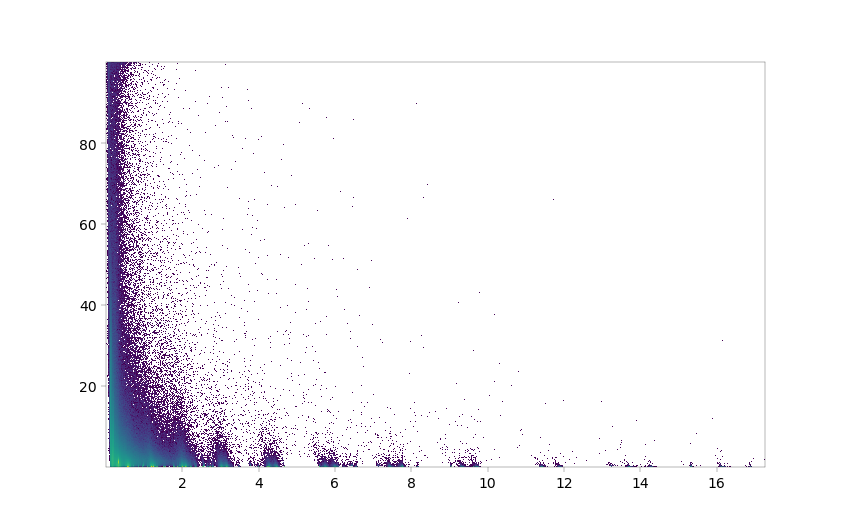

In [58]:
ind = slice(0,1000000)

# mu = -zeta_sc[ind] * omega_sc[ind] + 1j * omega_sc[ind] * np.sqrt(1 - zeta_sc[ind] ** 2 )
mu = -zeta_sc * omega_sc + 1j * omega_sc * np.sqrt(1 - zeta_sc ** 2 )

lamda = np.exp(mu/nyq_max)
mu = np.log(lamda)

f_k = np.abs(mu)/2/np.pi*nyq_max
zeta_k = 100*np.abs(np.real(mu))/np.abs(mu)
plt.figure()
# plt.plot(f_sc,d_sc, ls='none', marker=',')
plt.hist2d(f_sc,d_sc, bins=1000, norm='log')
# plt.plot(f_k,zeta_k, ls='none', marker=',')
# print(np.mean(np.abs(f_k-f_sc[ind])), np.mean(np.abs(zeta_k-d_sc[ind])))

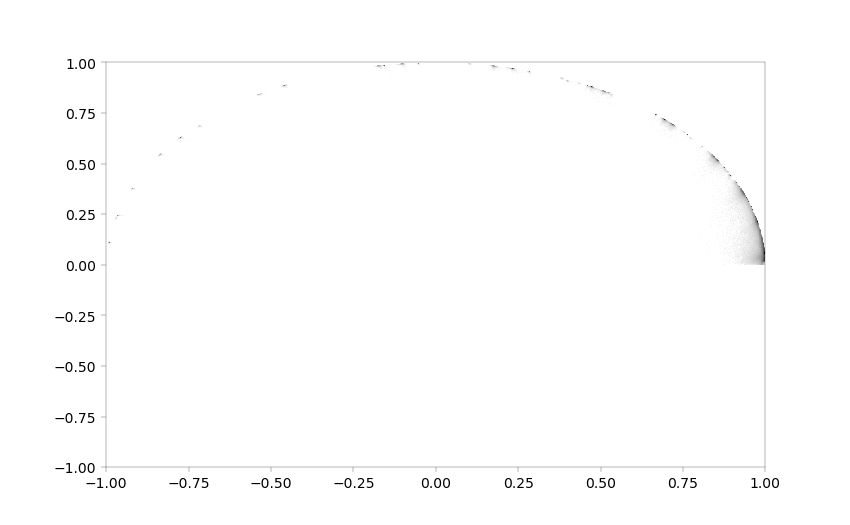

In [59]:
plt.figure()

# plt.plot(lamda.real, lamda.imag, ls='none', marker=',')
plt.hist2d(lamda.real,lamda.imag,bins=(np.linspace(-1.0,1.0,1000),np.linspace(-1.0,1.0,1000)), cmap='Greys', norm='log')
pass

#### OPTICS Clustering

In [48]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

In [60]:
clust = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
X = np.hstack((lamda.real[:,np.newaxis],lamda.imag[:,np.newaxis]))
rng = np.random.default_rng()
this_X = rng.choice(X,25000,False, axis=0)
clust.fit(this_X)

OPTICS(min_cluster_size=0.05, min_samples=10)

In [61]:
space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

In [62]:
labels = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.001,)
print(np.unique(labels))

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]


In [63]:
# plt.close('all')
# plt.figure()

# plt.plot(f_sc,d_sc, ls='none', marker=',')
for klass in np.unique(labels)[1:]:
    Xk = this_X[labels == klass]
    # mu_k = np.log(lamda)
    # omega_k = np.abs(mu_k)
    # f_k = omega_k / 2 / np.pi
    # zeta_k = lamda.real/omega_k * 100
    mu_k = np.log(1j*Xk[:,1]+Xk[:,0])

    f_k = np.abs(mu_k)/2/np.pi*nyq_max
    zeta_k = 100*np.abs(np.real(mu_k))/np.abs(mu_k)
    
    # a_i = np.abs(np.arctan2(Xk[:,1], Xk[:,0]))
    # b_i = np.log(np.sqrt(Xk[:,1]**2 + Xk[:,0]**2))
    # f_k = a_i/2/np.pi*35
    # zeta_k = 100*np.abs(b_i) / np.sqrt(a_i ** 2 + b_i ** 2)
    plt.plot(Xk[:, 0], Xk[:, 1], ls='none',marker=',')
    # plt.plot(f_k,zeta_k, ls='none', marker=',')
    # break

In [ ]:
plt.figure()
plt.hist(data, bins=np.linspace(0,5,1000))
pass
'''
Prerequisites:
- We have 21e6 identified modes 
- available modal parameters: frequencies, damping ratios (-> poles) and mode shapes 
- Input modes do not change (fixed structure), which would not be the case for multiple measurements taken on a real structure 
- (would have been nice to include environmental effects, temperature, as well -> was not considered in order to use FRF-based response synthetization, with a pre-computed FRF for all samples)
Goal:
- cluster them into n x 1000 modes, while discarding all remaining
- Use Fuzzy-Clustering, as proposed in the project description
Problems:
- It is likely not possible to cluster them all-at-once  (correlation matrix 1,7 PiB) even with classical clustering methods
- Multiple candidates for a given mode i might exist in a single sample of which one must be chosen
- Modeshapes have varying sensor locations, though reference sensors are always present and modes can be transformed to an aligned format
Roadmap:
- Possibly remove non-physical modes. How are they distinguished? Mode shapes can be complex and modal contributions are errorneous, depending on noise level, respectively
- A bootstrap / adaptive / iterative procedure should be chosen (the bootstrap might simply be achieved manually)
- Assign each identified mode a fuzzy membership for each "physical" mode
Try OPTICS algorithm! https://scikit-learn.org/stable/modules/clustering.html#optics
'''

In [ ]:
fig, axes = plt.subplots(5,4, sharex=True)

for da,ax in zip(in_ds, axes.flat):
    ind = ~np.isnan(out_ds[ret_name])
    in_da = in_ds[da][ind]
    out_da = out_ds[ret_name][ind]
    
    ax.hist2d(out_da, in_da,bins=100, cmap='Greys')
    # ax.scatter(out_da, in_da, s=1)
    ax.set_ylabel(da)
    ax.set_yticks([])

In [40]:

if 'sum' in ret_name:
    ret_name_org = ret_name.removeprefix('sum_')
    sum_mc = out_ds[ret_name_org].sum(dim='mode')
    # remove obviously wrong results -> caused by various bugs in the mapping -> might have to be corrected by re-propagating all samples
    # sum_mc[sum_mc<0] = np.nan
    # sum_mc[sum_mc>1] = np.nan
    ind = ((sum_mc<0)|(sum_mc>1))
    print(np.sum(ind))
    sum_mc[ind] = np.nan
    
    out_ds[ret_name] = np.abs(sum_mc)

<xarray.DataArray 'mc_cf' ()>
array(2)


(array([5.12968e+05, 2.00000e+00, 5.00000e+00, 1.00000e+01, 3.50000e+01,
        6.50000e+01, 1.30000e+02, 1.88000e+02, 2.17000e+02, 2.72000e+02,
        2.90000e+02, 3.42000e+02, 3.57000e+02, 3.81000e+02, 4.27000e+02,
        4.38000e+02, 4.72000e+02, 5.19000e+02, 5.32000e+02, 5.34000e+02,
        5.96000e+02, 6.14000e+02, 6.72000e+02, 6.90000e+02, 7.17000e+02,
        7.39000e+02, 7.58000e+02, 7.34000e+02, 7.55000e+02, 7.44000e+02,
        6.99000e+02, 7.82000e+02, 7.73000e+02, 8.01000e+02, 8.86000e+02,
        1.05600e+03, 1.24900e+03, 1.54700e+03, 1.94600e+03, 2.57600e+03,
        3.42800e+03, 4.90200e+03, 6.62400e+03, 9.61600e+03, 1.37250e+04,
        2.10710e+04, 3.30110e+04, 5.68600e+04, 1.21832e+05, 1.91411e+05]),
 array([0.        , 0.01993309, 0.03986618, 0.05979927, 0.07973236,
        0.09966545, 0.11959854, 0.13953163, 0.15946472, 0.17939781,
        0.1993309 , 0.21926399, 0.23919708, 0.25913018, 0.27906325,
        0.29899636, 0.31892943, 0.33886254, 0.35879561, 0.378728

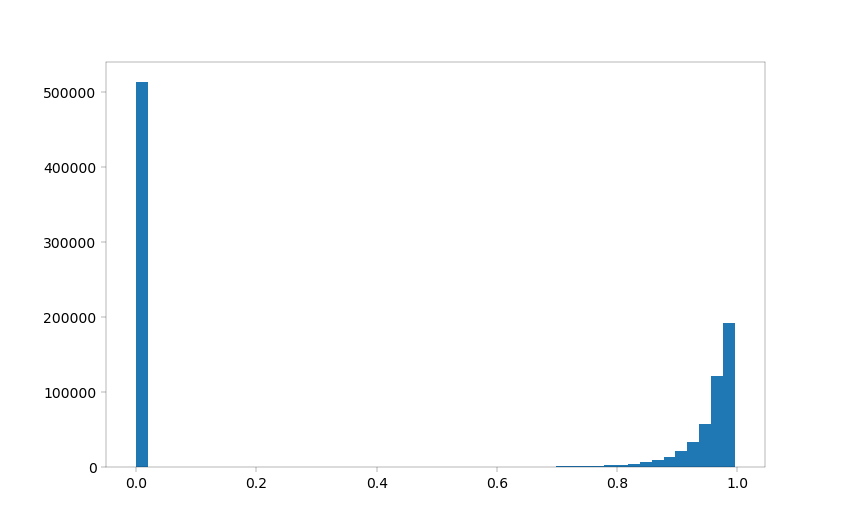

In [41]:
plt.figure()
plt.hist(out_ds[ret_name], bins=50)

In [9]:
def export(poly_uq, ret_name, ret_ind, out_ds, result_dir, pretty_ret_name):
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    samp_path = os.path.join(result_dir,'polyuq_samp.npz')
    prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
    imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')

    poly_uq.load_state(samp_path, differential='samp')
    poly_uq.N_mcs_ale = 1000
    
    if os.path.exists(prop_path):
        poly_uq.load_state(prop_path, differential='prop')
    if os.path.exists(imp_path):
        poly_uq.load_state(imp_path, differential='imp')
    
    poly_uq.from_data_manager(None, ret_name, ret_ind, out_ds, pretty_ret_name)
    
    poly_uq.save_state(prop_path, differential='prop')
    if os.path.exists(imp_path):
        poly_uq.save_state(imp_path, differential='imp')

In [ ]:
export(PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex), ret_name, ret_ind, out_ds, result_dir, pretty_ret_name)

### Investigate Cause of Failed Samples

**Outcomes of this analysis:**

Problems:
- spectral sensor noise had too many close-to-DC components in some cases
- SSIData validation measure was not properly normalized (not dividing by sigma_synth)
- pLSCF validation measure; only the complex modulus was stored, effectively summing up counter-phase split modes instead of canceling them out
- pLSCF did not use validation sets, but just the training sets

Solutions:
- SSIData was fixed
- Output storage of pLSCF was fixed in mapping
- an additional highpass filter at 0.1 Hz was implemented in mapping

Outcomes:
- from each OMA method the worst samples (11 upper  outliers and 11 lower outliers) and 11 random samples were chosen (not all in all cases) leading to 77 samples to compare
- Samples were recomputed and matched by MAC and frequency and compared
- The validation measure seems fixed
- the SSI methods lead to similar results
- the pLSCF method was quite severely affected and performs better now

Roadmap:
- find all wrong results for sum_mc
    - sum_mc_sc: 14 %, sum_mc_sd: 21 %, sum_mc_cf: 71 %
    - correlated mostly to both sensor noise parameters
- mask them with np.nan -> Anyways, results for ''high'' noise values will be errorneous
- upon encounter of further errors, e.g. when quantifying UQ on natural frequencies or the like, samples might have to be recomputed (takes weeks)
    - copy required measurements.npz and prep_signals.npz
    - and if any measurements.npz is missing the response.npz corresponding to id_ale
    - basically everything except modal.npz -> total ~26 TiB
    - run it in 16 (hex ids) chunks over ids 
    - this could already be started now but might be a problem, if further errors would be found later
- not using sum_mc's would be difficult to justify. Why was it developed in the first place, then?

In [ ]:
ids_sorted = out_ds.ids[np.argsort(out_ds['sum_mc_sc']).data]

print(ids_sorted[:11], out_ds['sum_mc_sc'].sel(ids=ids_sorted[:11]))
print(ids_sorted[-11:], out_ds['sum_mc_sc'].sel(ids=ids_sorted[-11:]))
chosen = np.random.choice(ids_sorted[11:-11], 11, False)
print(chosen, out_ds['sum_mc_sc'].sel(ids=chosen))

In [ ]:
selected_samples=[

# sum_mc_sd

# minima extremes
'1fe5b371_2f493f82', 'db11d07a_0e9f1c84', '34330bed_5b4e789f',
        'dac0943d_b30b1ac7', 'edc5b710_2a79f243', '69b47cc4_30af5a4b',
        '61ed219d_923a5705', '48a04da3_64c9ab6b', '3983482b_0cc2eb8d',
        '433de8cb_e2f29a6e', '94fa1e23_6fdaacf7',

# maxima extremes        
'35a4c902_697a64c5', '0aa6d38f_898743c5', 'ec4c0905_133e9cec',
        '712243d5_606ac5b3', 'd64a5baf_1da25cf9', '3bd279d8_128f5711',
        '75b18085_7a7b5162', '76457805_d49fc9d1', 'a4328abc_ee30b62b',
        '43c5ca92_3e6d36ce', '35a4c902_fa9c3e72',

# random in between
'01250170_4fd6b385', '40b5b712_83325e15', '70242bd8_128f5711',
       'dd8a1138_7691d8eb', 'd2b83277_e68fe9eb', '1079fc33_b4731c77',
       '34b23b35_6005d1e8', 'c415d1c6_14a42c5c', 'df01cda1_a5f6c5ad',
       'fa72de06_f7915fdf', '8a2a343d_32a6c562',
       
# sum_mc_sc

# minima extremes
'b835918c_2193470c', 'e356ab0d_f23eb39a', 'ff9eb8db_dd847b51',
       'b8a500e9_cad3f431', 'e5c2a083_f95276ac', '6eb57b71_64c9ab6b',
       '2f33a9c0_491faa25', 'a94924b1_e37dba5a', 'c7acb986_0cc2eb8d',
       '9655438d_86b6f6bd', '859b75c3_491faa25',

# maxima extremes are all below 1

# random in between
'5f191e52_9a32bab1', '143ee3b5_b1187610', '46b5cee4_7ffc5080',
 '8742b906_d342fcf3', 'd9282fac_d3bd0238', '433de8cb_99bd435e',
 'aca7cf9c_bda88d9e', '6042776e_92daae67', '8747574a_831b1fed',
 'e4963163_5f2e85a3', 'e941d876_632f36d7',
 
# sum_mc_cf

# minima are all higher than 1 due to abs

# maxima extremes 
'81fa6276_53b57325', '1203fb42_831b1fed', '7890bb15_5368f825',
       'a2aa8bec_53b57325', 'dcd85949_0de98288', '787ab4dc_923a5705',
       '13ebdcc2_8e67dadf', 'd691245f_1d5d8b9e', '4bc8dbf2_8e67dadf',
       'e07d5384_fb4ab6fa', '989aae05_53b57325',
       
# random in between
'fa72de06_9818b720', '8c5f6631_685c7022', 'e1f85a54_be7a879c',
 '5cc03d93_6ec21e16', 'b5315226_79b2b4d0', '1e927423_35e16917',
 'ff8cae07_4b504dfd', '2c1aeee8_cacea966', '819b476a_4c0c9ca2',
 'e07d5384_ec7ea0b5', '82c720c2_c3bf323a',
]

# generate rsync files list
# for jid in selected_samples:
#     id_ale, id_epi = id_ale, id_epi = jid.split('_')
#     print(f'{id_ale}/{id_epi}/')


In [ ]:
from pyOMA.core.PostProcessingTools import pair_modes, compare_modes

# @ray.remote(num_cpus=8)
def compare_fixed_mapping(jid, fun_kwargs, prev_res):

    # display(fun_kwargs, jid)
    this_working_dir = os.path.join(working_dir, jid)
    if not os.path.exists(this_working_dir):
        os.makedirs(this_working_dir)
    
    
    id_ale, id_epi = jid.split('_')
    this_result_dir = result_dir / 'samples' / id_ale / id_epi
    
    if os.path.exists(this_result_dir / 'modal.npz'): os.remove(this_result_dir / 'modal.npz')        

    bits_effective, snr_db_est, snr_db, \
    f_sc, d_sc, phi_sc, mc_sc, \
    f_cf, d_cf, phi_cf, mc_cf, \
    f_sd, d_sd, phi_sd, mc_sd, phi_indexer = stage2n3mapping(**fun_kwargs,
                                              jid=jid, 
                                              result_dir=result_dir/ 'samples', working_dir=working_dir, skip_existing=True)

    # display(bits_effective, snr_db_est, snr_db, channel_defs, f_sc, d_sc, phi_sc, mc_sc, f_cf, d_cf, phi_cf, mc_cf, f_sd, d_sd, phi_sd, mc_sd)
    # display(np.sum(mc_sc), np.abs(np.sum(mc_cf)), np.sum(mc_sd))
    # display(prev_res)
    # display(np.sum(prev_res['mc_sc']), np.sum(prev_res['mc_cf']), np.sum(prev_res['mc_sd']))
    # plt.figure()
    
    for (f,d,phi,mc),(nf,nd,nphi,nmc) in zip([(f_sc, d_sc, phi_sc, mc_sc),(f_cf, d_cf, phi_cf, mc_cf), (f_sd, d_sd, phi_sd, mc_sd)],
            [('f_sc', 'd_sc', 'phi_sc','mc_sc'),('f_cf', 'd_cf', 'phi_cf','mc_cf'), ('f_sd', 'd_sd', 'phi_sd','mc_sd')]):
        
        prev_ind = ~np.isnan(prev_res[nf])
        curr_ind =  ~np.isnan(f)
        # print(f'New Validation Estimate: {np.sum(mc)}, Old Validation Estimate: {np.sum(prev_res[nmc]).item()}')
        inds_a, inds_b, unp_a, unp_b = compare_modes(f[curr_ind], d[curr_ind], phi[:,curr_ind], 
                      prev_res[nf][prev_ind], prev_res[nd][prev_ind], prev_res[nphi][:phi.shape[0],prev_ind])
        # plt.figure()
        # plt.plot(f[curr_ind], d[curr_ind], marker='x', color='black', ls='none')
        # plt.plot(prev_res[nf][prev_ind], prev_res[nd][prev_ind], marker='+', color='black', ls='none')
        # for ind_a, ind_b in zip(inds_a, inds_b):
        #     fs = (f[ind_a],prev_res[nf][ind_b])
        #     ds = (d[ind_a],prev_res[nd][ind_b])
        #     plt.plot(fs, ds, color='red')
        plt.title(f'New Validation Estimate: {np.sum(mc)}, Old Validation Estimate: {np.nansum(prev_res[nmc]).item()}')
        plt.savefig(f'/scratch/sima9999/modal_uq/uq_oma_a/compare_fixed_mapping/{jid}_{nf}_damp.png')
        plt.close()
        plt.savefig(f'/scratch/sima9999/modal_uq/uq_oma_a/compare_fixed_mapping/{jid}_{nf}_mac.png')
        plt.close()
        
ray.shutdown()
ray.init(address='auto', _redis_password='5241590000000000')

futures = []
for jid in ['1fe5b371_2f493f82']:
    fun_kwargs = {}
    dssel= in_ds.sel(ids = jid)
    for arg, var in arg_vars.items():
        if not isinstance(var, str):
            logger.warning(f'The variable name that was passed for argument {arg} should be a string but is a {type(var)}')
        fun_kwargs[arg] = dssel[var].item()
    print(fun_kwargs)
    this_out = out_ds.sel(ids=jid)
    prev_res = {dv:this_out[dv].data for dv in this_out.data_vars}
    
    compare_fixed_mapping(jid, fun_kwargs, prev_res)
    # futures.append(compare_fixed_mapping.remote(jid, fun_kwargs, prev_res))

### Sensitivity Analysis

In [ ]:
S1_var, conf_var, names = poly_uq.estimate_sensi(method='var',y_resamples=10000)
poly_uq.save_state(sens_path, differential='sens')
S1_dens, conf_dens, names = poly_uq.estimate_sensi(method='dens',y_resamples=10000)

In [ ]:
from helpers import get_pcd
num_params = len(names)
with matplotlib.rc_context(get_pcd('print')):
    fig, axes = plt.subplots(2,1, sharex=True, sharey=True)
    
    eb_cont = axes[0].errorbar(np.arange(num_params), S1_var, [S1_var-conf_var[0],conf_var[1]-S1_var], 
                           marker='+', ls='none', capsize=3,  color='dimgrey')
    eb_cont = axes[1].errorbar(np.arange(num_params), S1_dens, [S1_dens-conf_dens[0],conf_dens[1]-S1_dens], 
                           marker='+', ls='none', capsize=3,  color='dimgrey')
     
    plt.ylim(ymin=0)
    plt.xlabel('Input Variables $i$')
    axes[0].set_ylabel('$\hat{S}_{1,i}$')
    axes[1].set_ylabel('$\hat{\delta}_i$')
    fig.supylabel('Sensitivities', y=0.6)
    
    labels = [var.pretty_name for var in vars_ale if var.primary] + [var.pretty_name for var in vars_epi if var.primary]
    axes[0].set_title(poly_uq.pretty_out_name)
    axes[1].set_xticks(np.arange(num_params), labels, rotation=90)
    plt.subplots_adjust(top=0.93,bottom=0.2, left=0.13, right=0.97, hspace=0.05)
    plt.show()
    plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/sensi_{ret_dir}.pdf', backend='pgf')
    plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/sensi_{ret_dir}.png', backend='pgf')

In [ ]:
# 'dens' is inconsistent for sum_mc_sd due to implementation errors in SSIData
multi_sensi(vars_ale, vars_epi,result_dir, ['snr_db','snr_db_est', 
                                           # 'f_sc','f_cf', 'f_sd', 'd_sd', 
                                            'sum_mc_sc', 'sum_mc_cf', 'sum_mc_sd'],'var')


### Evaluate RBF interpolation parameters

In [ ]:
def test_interpolation(ret_name, ret_ind, N_mcs_ale):
    # evaluates 10 ale samples and returns the leave-100-out validation measure (over all imprecision samples) of the interpolator
    
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    
    samp_path = os.path.join(result_dir,'polyuq_samp.npz')
    prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
    imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')    
    
    poly_uq = PolyUQ(vars_ale,  sensitive_vars(ret_name, vars_epi), dim_ex=dim_ex)
    poly_uq.load_state(samp_path, differential='samp')
    poly_uq.load_state(prop_path, differential='prop')
    
    poly_uq.N_mcs_ale=N_mcs_ale
    poly_uq.estimate_imp(
        interp_fun='rbf',
        opt_meth='genetic',
        plot_res=False,
        plot_intp=False,
        intp_err_warn = 20,
        extrp_warn = 10,
        start_ale = poly_uq.N_mcs_ale - 10, 
        kernel='gaussian',
        # smoothing=100, # check 0 (default), 1, 10, 0.1, 100 # 0 or 0.1 is best 
        epsilon=epsilon_dict[ret_name]
        )
    # poly_uq.save_state(os.path.join(result_dir,'estimations', f'{ret_dir}/polyuq_imp.npz'))
    return poly_uq.intp_errors, poly_uq.intp_exceed, poly_uq.intp_undershot

In [ ]:
# ray.shutdown()
# ray.init(address='auto', _redis_password='5241590000000000')

all_intp_errors = {'snr_db':[None for _ in range(30)], #0
                    'snr_db_est':[None for _ in range(30)], #1
                    'f_sc':[None for _ in range(30)], #2
                    'f_cf':[None for _ in range(30)], #3
                    'f_sd':[None for _ in range(30)], #4
                    'd_sd':[None for _ in range(30)], #5
                    'sum_mc_sc':[None for _ in range(30)], #6
                    'sum_mc_cf':[None for _ in range(30)], #7
                    'sum_mc_sd':[None for _ in range(30)],}
all_intp_exceed = {'snr_db':[None for _ in range(30)], #0
                    'snr_db_est':[None for _ in range(30)], #1
                    'f_sc':[None for _ in range(30)], #2
                    'f_cf':[None for _ in range(30)], #3
                    'f_sd':[None for _ in range(30)], #4
                    'd_sd':[None for _ in range(30)], #5
                    'sum_mc_sc':[None for _ in range(30)], #6
                    'sum_mc_cf':[None for _ in range(30)], #7
                    'sum_mc_sd':[None for _ in range(30)],}
all_intp_undershot = {'snr_db':[None for _ in range(30)], #0
                    'snr_db_est':[None for _ in range(30)], #1
                    'f_sc':[None for _ in range(30)], #2
                    'f_cf':[None for _ in range(30)], #3
                    'f_sd':[None for _ in range(30)], #4
                    'd_sd':[None for _ in range(30)], #5
                    'sum_mc_sc':[None for _ in range(30)], #6
                    'sum_mc_cf':[None for _ in range(30)], #7
                    'sum_mc_sd':[None for _ in range(30)],}

epsilon_dict = {'snr_db':3.5,
                 'snr_db_est':3.5,
                 'f_sc':2,
                 'f_cf':2,
                 'f_sd':2,
                 'd_sd':2,
                 'sum_mc_sc':5.5, # 6 seems a good start : approximate average distance between nodes (which is a good start)
                 'sum_mc_cf':5.5,
                 'sum_mc_sd':5.5}

In [ ]:
@ray.remote(num_cpus=4)
def sub_test(i, ret_name, N_mcs):
    ret_ind = {}
    
    return i, ret_name,  *test_interpolation(ret_name, ret_ind, N_mcs)

all_MCS ={'snr_db':[], #0
                    'snr_db_est':[], #1
                    'f_sc':[], #2
                    'f_cf':[], #3
                    'f_sd':[], #4
                    'd_sd':[], #5
                    'sum_mc_sc':[], #6
                    'sum_mc_cf':[], #7
                    'sum_mc_sd':[]}
futures = []
for ret_name in [#'snr_db', #0
                    'snr_db_est', #1
                    # 'f_sc', #2
                    # 'f_cf', #3
                    # 'f_sd', #4
                    # 'd_sd', #5
                    # 'sum_mc_sc', #6
                    # 'sum_mc_cf', #7
                    # 'sum_mc_sd'
                ]:

    N_mcs = np.random.randint(10,1000,30)
    all_MCS[ret_name] = N_mcs
    for i in range(30):
        if all_intp_errors[ret_name][i] is not None: continue
        # sub_test(i, ret_name, N_mcs[i])
        futures.append(sub_test.remote(i, ret_name, N_mcs[i]))

futures = set(futures)

In [ ]:
while True:
    ready, wait = ray.wait(
        list(futures), num_returns=min(len(futures), 10), timeout=30)
    try:
        ret_sets = ray.get(ready)
        size_before = len(futures)
        for i, ret_name, intp_errors, intp_exceed, intp_undershot in ret_sets:
        #     assert all_intp_errors[ret_name][i] is None
            all_intp_errors[ret_name][i] = intp_errors
        #     assert all_intp_exceed[ret_name][i] is None
            all_intp_exceed[ret_name][i] = intp_exceed
        #     assert all_intp_undershot[ret_name][i] is None
            all_intp_undershot[ret_name][i] = intp_undershot
            
        futures.difference_update(ready)
        print(f"Finished {len(ready)} samples. Remaining {len(futures)} samples. (before {size_before})")
    except Exception as e:
        print(e)
        # futures.difference_update(ready)
        pass
    if len(futures) == 0:
        break

In [ ]:
plt.close('all')
for ret_name in [#'snr_db', #0
                    'snr_db_est', #1
                    # 'f_sc', #2
                    # 'f_cf', #3
                    # 'f_sd', #4
                    # 'd_sd', #5
                     # 'sum_mc_sc', #6
                    # 'sum_mc_cf', #7
                    # 'sum_mc_sd'
                ]:
    '''
    draw 30 histograms of intp_errors (overlaying transparent)
    draw histogram of average exceed / undershot percent
    '''
    this_intp_errors = all_intp_errors[ret_name]
    plt.figure()
    for intp_errors in this_intp_errors:
        if intp_errors is None: continue
        plt.hist(intp_errors*100, bins=np.arange(101), alpha=0.1)
    plt.title(f'interpolator validation measure {ret_name} w. RBF @ {epsilon_dict[ret_name]}')
    plt.savefig(f'intrp-vali_{ret_name}_rbf-{epsilon_dict[ret_name]}.png')
    # continue
    all_undershots = []
    num_undershots = []
    for undershot in all_intp_undershot[ret_name]:
        if undershot is None: continue
        if not undershot[0]: continue
        all_undershots.append(undershot[1] / undershot[0])
        num_undershots.append(undershot[0])
    plt.figure()
    plt.hist(all_undershots, weights= num_undershots)
    plt.title(f'average undershot error (non-normalized scaling) {ret_name} w. RBF @ {epsilon_dict[ret_name]}')
    plt.savefig(f'unde-err_{ret_name}_rbf-{epsilon_dict[ret_name]}.png')
#     plt.figure()
#     plt.hist(num_undershots)
#     plt.title(ret_name + ' undershot numbers')
    all_exceeds = []
    num_exceeds = []
    for exceed in all_intp_exceed[ret_name]:
        if exceed is None: continue
        if not exceed[0]: continue
        all_exceeds.append(exceed[1] / exceed[0])
        num_exceeds.append(exceed[0])
    plt.figure()
    plt.hist(all_exceeds, weights= num_exceeds)
    plt.title(f'average exceedance error (non-normalized scaling) {ret_name} w. RBF @ {epsilon_dict[ret_name]}')
    plt.savefig(f'exce-err_{ret_name}_rbf-{epsilon_dict[ret_name]}.png')
#     plt.figure()
#     plt.hist(num_exceeds)
#     plt.title(ret_name + ' exceed numbers')
    

### Estimate imprecision

In [ ]:
# @ray.remote(num_cpus=64)
def est_imp(poly_uq, result_dir, ret_name, ret_ind):
    os.environ["MKL_NUM_THREADS"] = "64" 
    os.environ["OMP_NUM_THREADS"] = "64" 
    # from SciPy Docs: approximate average distance between nodes (which is a good start)
    epsilon_dict = {'snr_db':3.5,
                 'snr_db_est':3.5,
                 'f_sc':2,
                 'f_cf':2,
                 'f_sd':2,
                 'd_sd':2,
                 'sum_mc_sc':5.5,
                 'sum_mc_cf':5.5,
                 'sum_mc_sd':5.5}

    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'

    samp_path = os.path.join(result_dir, 'polyuq_samp.npz')
    prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
    imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')

    poly_uq.load_state(samp_path, differential='samp')
    poly_uq.load_state(prop_path, differential='prop')
    # poly_uq.N_mcs_ale = 13717

    start_ale = 0

    if os.path.exists(imp_path):
        poly_uq.load_state(imp_path, differential='imp')

        samp_unfin = np.nonzero(
                np.any(
                    np.isnan(poly_uq.imp_foc[:,:, 0]),
                    axis=1)
            )[0]

        samp_unfin = samp_unfin[samp_unfin > start_ale]

        if len(samp_unfin) > 0:
            start_ale = np.min(samp_unfin)
        else:
            start_ale = poly_uq.imp_foc.shape[0]

    while start_ale < poly_uq.N_mcs_ale:
        print(f'restarting {ret_dir} at sample {start_ale}')
        end_ale = min(start_ale + 100, poly_uq.N_mcs_ale)
        poly_uq.estimate_imp(
            interp_fun='rbf',
            opt_meth='genetic',
            plot_res=False,
            plot_intp=False,
            intp_err_warn=20,
            extrp_warn=10,
            start_ale=start_ale,
            end_ale=end_ale,
            kernel='gaussian',
            epsilon=epsilon_dict[ret_name]
        )
        poly_uq.save_state(imp_path, differential='imp')
        start_ale = end_ale

In [ ]:
# ret_ind = {'frequencies':533, 'space':1}
# ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
poly_uq = PolyUQ(vars_ale, sensitive_vars(ret_name, vars_epi), dim_ex=dim_ex)

est_imp(poly_uq, result_dir, ret_name, ret_ind)
# opt_inc(poly_uq, result_dir, ret_name, ret_ind)

In [ ]:
ray.shutdown()
ray.init(address='auto', _redis_password='5241590000000000')
remote_est_imp = ray.remote(num_cpus=64)(est_imp)
# remote_est_imp = est_imp
remote_opt_inc = ray.remote(num_cpus=64)(opt_inc)

futures=[]
# takes about 1 day on 64 cores per ret_name
for ret_name in [
                # 'snr_db',
                'snr_db_est',
                'sum_mc_sc', 
                # 'sum_mc_cf', 
                'sum_mc_sd'
                ]:
    ret_ind = {}


    poly_uq = PolyUQ(vars_ale, sensitive_vars(ret_name, vars_epi), dim_ex=dim_ex)
    # test_cores.remote()
    # futures.append(remote_est_imp.remote(poly_uq, result_dir, ret_name, ret_ind))
    futures.append(remote_opt_inc.remote(poly_uq, result_dir, ret_name, ret_ind))


In [ ]:
ray.get(futures)

In [ ]:
ray.shutdown()

In [ ]:
plt.close('all')
for ret_name in [
                'snr_db',
                'snr_db_est',
                'sum_mc_sc', 
                'sum_mc_cf', 
                'sum_mc_sd']:
    
    fig1, ax1 = plt.subplots()
    
    all_undershots = []
    num_undershots = []
    all_exceeds = []
    num_exceeds = []

    ret_ind = {}
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    samp_path = os.path.join(result_dir,'polyuq_samp.npz')
    prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
    imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')

    if not os.path.exists(imp_path): continue

    poly_uq.load_state(samp_path, differential='samp')
    poly_uq.load_state(prop_path, differential='prop')
    poly_uq.load_state(imp_path, differential='imp')

    if poly_uq.imp_foc is not None:
        samp_unfin = np.nonzero(
                np.any(
                    np.isnan(poly_uq.imp_foc[:,:,0]),
                    axis=1)
            )[0]
        print(samp_unfin)
        if len(samp_unfin)>0:
            start_ale = np.min(samp_unfin)
        else:
            start_ale = poly_uq.imp_foc.shape[0]
        print(start_ale)

    undershot = poly_uq.intp_undershot
    all_undershots.append(undershot[1] / undershot[0] / (poly_uq.out_valid[1]-poly_uq.out_valid[0])*100)
    all_undershots.append(0)
    num_undershots.append(undershot[0])
    num_undershots.append(poly_uq.N_mcs_ale*len(poly_uq.imp_hyc_foc_inds) - undershot[0])

    exceed = poly_uq.intp_exceed
    all_exceeds.append(exceed[1] / exceed[0] / (poly_uq.out_valid[1]-poly_uq.out_valid[0])*100)
    all_exceeds.append(0)
    num_exceeds.append(exceed[0])
    num_exceeds.append(poly_uq.N_mcs_ale*len(poly_uq.imp_hyc_foc_inds) - exceed[0])

    ax1.hist(100-poly_uq.intp_errors*100, bins=np.arange(101), alpha=0.1)
        
    ax1.set_title(f'Interpolator LOO Cross-Validation {ret_name}')
    ax1.set_xlabel("Accuracy [\%]")
    ax1.set_ylabel("Sample Count [-]")
    fig1.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/imp_loo_accuracy{ret_name}.png')
    fig1.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/imp_loo_accuracy{ret_name}.pdf')

    plt.figure()
    plt.hist(all_undershots, weights= num_undershots, bins=50)
    plt.title(ret_name + ' undershot error')

    plt.figure()
    plt.hist(all_exceeds, weights= num_exceeds, bins=50)
    plt.title(ret_name + ' exceed error') 

In [ ]:

def opt_inc(poly_uq, result_dir, ret_name, ret_ind):
    
    os.environ["MKL_NUM_THREADS"] = "64" 
    os.environ["OMP_NUM_THREADS"] = "64" 
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
    samp_path = os.path.join(result_dir,'polyuq_samp.npz')
    prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
    imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')
        
    poly_uq.load_state(samp_path, differential='samp')
    poly_uq.load_state(prop_path, differential='prop')
    poly_uq.load_state(imp_path, differential='imp')
    

    def run_inc(poly_uq, inc_path, stat_fun, stat_fun_kwargs={}):
        print(stat_fun.__name__)
        if os.path.exists(inc_path) and False:
            print(f'{inc_path} already finished.')
            return
            poly_uq.load_state(inc_path)
        
        focals_stats, hyc_mass = poly_uq.optimize_inc(stat_fun, stat_fun.n_stat, stat_fun_kwargs)
        poly_uq.save_state(inc_path, differential='inc')
        

    if True: # Average
        inc_path_part = 'polyuq_avg_inc.npz'
        inc_path = os.path.join(result_dir, 'estimations', ret_dir, inc_path_part)
        
        run_inc(poly_uq, inc_path, stat_fun_avg)
        
    if False: # Confidence Interval
        inc_path_part = 'polyuq_ci_inc.npz'
        inc_path = os.path.join(result_dir, 'estimations', ret_dir, inc_path_part)
        
        run_inc(poly_uq, inc_path, stat_fun_ci)
        
    if False: # Confidence Interval Length
        inc_path_part = 'polyuq_lci_inc.npz'
        inc_path = os.path.join(result_dir, 'estimations', ret_dir, inc_path_part)
        
        run_inc(poly_uq, inc_path, stat_fun_lci)
    
    if True: # Histogram
        nbin_fact=20
        n_imp_hyc = len(poly_uq.imp_hyc_foc_inds)
        bins_densities = generate_histogram_bins(poly_uq.imp_foc.reshape(poly_uq.N_mcs_ale, n_imp_hyc * 2), 1, nbin_fact/2) # divide nbin_fact by 2 to account for reshaping intervals
        stat_fun_hist.n_stat = len(bins_densities) - 1
        cum_dens = False
        stat_fun_kwargs = {'bins_densities':bins_densities, 'cum_dens':cum_dens}#, 'ax':ax1}
        
        inc_path_part = 'polyuq_hist_inc.npz'
        inc_path = os.path.join(result_dir, 'estimations', ret_dir, inc_path_part)
        
        run_inc(poly_uq, inc_path, stat_fun_hist, stat_fun_kwargs)
        
    if True: # Cumulative Density Function
        n_stat = 40
        target_probabilities = np.linspace(0,1,n_stat)
        stat_fun_cdf.n_stat = n_stat
        stat_fun_kwargs = {'target_probabilities':target_probabilities}
        inc_path_part = 'polyuq_cdf_inc.npz'
        inc_path = os.path.join(result_dir, 'estimations', ret_dir, inc_path_part)
        
        run_inc(poly_uq, inc_path, stat_fun_cdf, stat_fun_kwargs)


### Plots

In [ ]:
plt.close('all')

for ret_name in ret_names:
    with matplotlib.rc_context(get_pcd('print')):

        plt.figure()
        ret_ind = {}
        ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
        ret_file = os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_avg_inc.npz')
        if not os.path.exists(ret_file): continue
        arr = np.load(ret_file)
        focals_stats, focals_mass = arr['self.focals_stats'], arr['self.focals_mass']

        plot_focals(focals_stats[0,:,:], focals_mass, plt.gca())
        plt.xlabel(pretty_ret_names[ret_name])

        plt.ylim((0,1))
        plt.ylabel('Cumulative Mass [-]')

        plt.subplots_adjust(top=0.97, bottom=0.135, left=0.105, right=0.97, wspace=0.045)

        plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/inc_avg_foc-{ret_dir}.png')
        plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/inc_avg_foc-{ret_dir}.pdf')


        plt.show()

In [ ]:
for ret_name in ret_names:
    with matplotlib.rc_context(get_pcd('print')):

        ret_ind = {}
        ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'
        ret_file = os.path.join(result_dir,'estimations',f'{ret_dir}/polyuq_avg_inc.npz')
        if not os.path.exists(ret_file): continue
        arr = np.load(ret_file)
        focals_stats, focals_mass = arr['self.focals_stats'], arr['self.focals_mass']

        bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)

        # what does that do? some kind of differentiation?
        dbins = np.diff(bins_bel)
        pl_stats[0,1:] /= dbins
        # print(pl_stats.shape, bins_bel.shape)
        bins_bel = np.insert(bins_bel, 0, bins_bel[0], axis=0)
        bins_bel = np.append(bins_bel, bins_bel[-1:], axis=0)
        pl_stats = np.insert(pl_stats, 0, 0, axis=1)
        pl_stats = np.append(pl_stats, [[0]], axis=1)

        fig, ax = plt.subplots(1,1, sharey=True)
        ax.step(bins_bel, pl_stats[0,:], where='post',
                label=pretty_ret_names[ret_name], color='dimgrey'
               )
        # ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        # ax.legend(loc='upper left')
        ax.set_xlabel(pretty_ret_names[ret_name])
# 



        ax.set_ylim(ymin=0)
        ax.set_ylabel('Mass Density [$\sfrac{1}{\si{\hertz}}$]')

        plt.subplots_adjust(top=0.99, bottom=0.22, left=0.115, right=0.97, wspace=0.12)
        
        plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/inc_avg_pl-{ret_dir}.png')
        plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/inc_avg_pl-{ret_dir}.pdf')
        plt.show()


In [ ]:
plt.close('all')
for ret_name in ret_names:
    
    ret_ind = {}
    ret_dir = f'{ret_name}-{".".join(str(e) for e in ret_ind.values())}'

    poly_uq = PolyUQ(vars_ale, sensitive_vars(ret_name, vars_epi), dim_ex=dim_ex)

    samp_path = os.path.join(result_dir,'polyuq_samp.npz')
    prop_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_prop.npz')
    imp_path = os.path.join(result_dir, 'estimations', f'{ret_dir}/polyuq_imp.npz')
    
    
    
    for inc_path_part in ['polyuq_hist_inc.npz', 'polyuq_cdf_inc.npz']:

        # inc_path_part = 'polyuq_hist_inc.npz'
        # inc_path_part = 'polyuq_cdf_inc.npz'
        inc_path = os.path.join(result_dir, 'estimations', ret_dir, inc_path_part)
        
        if not os.path.exists(inc_path): continue
        
        poly_uq.load_state(samp_path, differential='samp')
        poly_uq.load_state(prop_path, differential='prop')
        poly_uq.load_state(imp_path, differential='imp')
        poly_uq.load_state(inc_path, differential='inc')
        focals_stats, focals_mass = poly_uq.focals_stats, poly_uq.focals_mass
        n_stat = focals_stats.shape[0]
        if False:
            fix, axes = plt.subplots(8,5,sharex=True, sharey=True)
            for i_stat in range(n_stat):
                plot_focals(focals_stats[i_stat,:,:],focals_mass, axes.flat[i_stat])

        bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)
        n_bins_bel = bins_bel.shape[0]
        with matplotlib.rc_context(get_pcd('print')):

            if 'cdf' in inc_path_part:
                plt.figure()
                n_stat,n_hyc,_ = focals_stats.shape
                target_probabilities = np.linspace(0,1,n_stat)
                for i_hyc in range(n_hyc):
                    for minmax in range(2):
                        plt.step(focals_stats[:,i_hyc,minmax],target_probabilities,  where='post', c='grey')
                plt.ylabel('Cumulative Probability [$-$]')
                plt.xlabel(pretty_ret_names[ret_name])

                plt.ylim((0,1))
                plt.xlim((np.nanmin(focals_stats), np.nanmax(focals_stats))) 
                plt.subplots_adjust(top=0.975,bottom=0.145, left=0.09,right=0.98)
                plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/inc_cdf_foc-{ret_dir}.png')
                plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/inc_cdf_foc-{ret_dir}.pdf')

            if True:
                plt.figure()
                if 'hist' in inc_path_part:
                    nbin_fact=20
                    n_imp_hyc = len(poly_uq.imp_hyc_foc_inds)
                    bins_densities = generate_histogram_bins(poly_uq.imp_foc.reshape(poly_uq.N_mcs_ale, n_imp_hyc * 2), 1, nbin_fact/2)

                    # db = np.array(np.diff(bins_densities), float)
                    # for i_hyc in range(focals_stats.shape[1]):
                    #     for mi_ma in range(2):
                    #         focals_stats[:,i_hyc,mi_ma] /= db#*np.sum(focals_stats[:,i_hyc,mi_ma])
                    # bel_stats, pl_stats, q_stats, bins_bel = aggregate_mass(focals_stats, focals_mass, 10, False)
                    # n_bins_bel = bins_bel.shape[0]

                    plt.pcolormesh(bins_densities[:-1], bins_bel, pl_stats.T, cmap='Greys')#, shading='gouraud')
                    cbar = plt.colorbar()
                    cbar.set_label('Plausibility [-]')
                    plt.ylabel('Weighted Count ')
                    plt.xlabel(pretty_ret_names[ret_name])

                    plt.ylim((bins_bel.min(), bins_bel.max()))
                    plt.xlim((bins_densities.min(), bins_densities.max()))
                    plt.subplots_adjust(top=0.975,bottom=0.145, left=0.1,right=1.0)
                    plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/inc_hist_pl-{ret_dir}.png')
                    plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/inc_hist_pl-{ret_dir}.pdf')

                elif 'cdf' in inc_path_part:
                    n_stat = pl_stats.shape[0]
                    target_probabilities = np.linspace(0,1,n_stat)
                    plt.pcolormesh(bins_bel, target_probabilities, pl_stats, cmap='Greys')#, shading='gouraud')
                    cbar = plt.colorbar()
                    cbar.set_label('Plausibility [-]')
                    plt.ylabel('Cumulative Probability [$-$]')

                    plt.xlabel(pretty_ret_names[ret_name])

                    plt.ylim((0,1))
                    plt.xlim((bins_bel.min(), bins_bel.max()))
                    plt.subplots_adjust(top=0.975,bottom=0.145, left=0.09,right=1.0)
                    plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/inc_cdf_pl-{ret_dir}.png')
                    plt.savefig(f'/home/sima9999/2019_OMA_UQ/tex/figures/examples/uq_oma_a/inc_cdf_pl-{ret_dir}.pdf')

            #plt.show()
            # break

##### CONTINUE HERE

- Create reasonable "categories" for filtering plots by selecting a subset of hypercubes
- Implement fuzzy clustering

In [ ]:
ray.shutdown()